# Developed by Jonathan Ojeda 29/1/2021 QAAFI UQ

_**Functionalities:**_

* Read netCDF using xarray
* Convert xarray to 2D pandas dataframe
* Create multi-dimensional xarray from 2D pandas dataframe
* Explore and plot multidimensional files using xarray 
* Create single maps and multi-maps using xarray
* Map correlations of variables included in the netCDF file
* Plot heatmaps using environmental variables
* Calculate summary statistics
* Prepare data for variance decomposition analysis
* Create probability density function plots
* Create scatter plots combining factors and variables

This code include the analysis of the output data from pSIMSV2 used to write a paper for the TERRA Project focused on the analysis of regional sorghum biomass in the USA.

In [1]:
#Import required packages
import os
os.environ["PROJ_LIB"] = r'C:\Users\uqjojeda\Anaconda3\Library\share'; #fixr
from netCDF4 import Dataset
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import matplotlib.ticker as ticker
import glob
import geopandas as gpd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Tool to minimize code and see only figures
This allows to close code and only visualise the visual output (figures and plots) of a cell only adding the following code 
`hide_toggle()` at the end of the cell. However the following cell need to be run at the begining of the code.

In [2]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

# Description of outputs generated by pSIMSV2

* run005 --> harvesting at 200 DAS.
* run004 --> harvesting at 300 degre days after flowering.
* r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\output.nc4' --> harvesting at 150 DAS.
* run007 --> harvesting at 120 DAS.
* run008 --> harvesting at 120 DAS withouth crop mask.
* run012 --> harvesting at 120 DAS withouth crop mask, some variables of stress and remaining tiles in Texas were added.
* run013 --> harvesting at 120 DAS withouth crop mask, add partitioned variables for climate.
* run014 --> same than run013 but with a change in the irrigation routine
* run016 --> change in planting dates to corn planting date.
* run017 --> change in planting dates to corn planting and ET values were added as variables
* run019 --> new variable sowing date at 30 arc-minute resolution was added (this outputs was used to write the paper)

### Read and merge all nc4 files from pSIMSV2

_Note: if more than a file in a folder write *.nc4 at the end of the address_

In [40]:
df_final = xr.merge([xr.open_dataset(f, decode_times=False) for f in glob.glob(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\new\run019\output.nc4')])

### Write a nc4 file

_Note: this is useful when several nc files were merged in the previous code_

In [5]:
#df_final.to_netcdf(r'C:/Users/uqjojeda/Nextcloud/PURTERRA-A0131/2020/outputs/new/run00/all_final.nc')

### Explore nc4 file (xarray data explanation)

_Coordinates and Dimensions:_

* `irr`: irrigation treatments (n=2) (1=rainfed, 2=irrigated under non water limitations),
* `lat`: latitudes (n=52),
* `lon`: longitudes (n=72),
* `scen_new`: cultivar (n=4) (GS (grain sorghum), SS (sudangrass sorghum), PS (photosensitive sorghum) and PI (photoinsensitive sorghum))
* `time`: years (n=30) (from 1980 to 2009, i.e. year number 1 is 1980)

_Data Variables:_ Here we have 41 variables which are the APSIM outputs specified in the parameter file in pSIMSV2.

In [15]:
df_final

<xarray.Dataset>
Dimensions:          (irr: 2, lat: 52, lon: 72, scen_new: 4, time: 30)
Coordinates:
  * irr              (irr) int32 1 2
  * lat              (lat) float64 49.75 49.25 48.75 48.25 ... 25.25 24.75 24.25
  * lon              (lon) float64 -107.8 -107.2 -106.8 ... -73.25 -72.75 -72.25
  * time             (time) int32 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30
Dimensions without coordinates: scen_new
Data variables:
    DOY              (time, scen_new, irr, lon, lat) float32 ...
    DaysAfterSowing  (time, scen_new, irr, lon, lat) float32 ...
    ESW1av           (time, scen_new, irr, lon, lat) float32 ...
    FloweringDAS     (time, scen_new, irr, lon, lat) float32 ...
    IrrigationIn     (time, scen_new, irr, lon, lat) float32 ...
    LeafNo           (time, scen_new, irr, lon, lat) float32 ...
    MaxLAI           (time, scen_new, irr, lon, lat) float32 ...
    N_stress_expan   (time, scen_new, irr, lon, lat) float32 ...
    N_stress_photo   (time, scen_new, irr, lon, lat) float32 ...
    PAWC             (time, scen_new, irr, lon, lat) float32 ...
    RadiationIn      (time, scen_new, irr, lon, lat) float32 ...
    RainIn           (time, scen_new, irr, lon, lat) float32 ...
    TempIn           (time, scen_new, irr, lon, lat) float32 ...
    WU               (time, scen_new, irr, lon, lat) float32 ...
    aMaxT            (time, scen_new, irr, lon, lat) float32 ...
    aMinT            (time, scen_new, irr, lon, lat) float32 ...
    actual_ET        (time, scen_new, irr, lon, lat) float32 ...
    biomass          (time, scen_new, irr, lon, lat) float32 ...
    planting_date    (time, scen_new, irr, lon, lat) float32 ...
    potential_ET     (time, scen_new, irr, lon, lat) float32 ...
    rad40DAS         (time, scen_new, irr, lon, lat) float32 ...
    rad80DAS         (time, scen_new, irr, lon, lat) float32 ...
    radHarv          (time, scen_new, irr, lon, lat) float32 ...
    rain40DAS        (time, scen_new, irr, lon, lat) float32 ...
    rain80DAS        (time, scen_new, irr, lon, lat) float32 ...
    rainHarv         (time, scen_new, irr, lon, lat) float32 ...
    ri0_40           (time, scen_new, irr, lon, lat) float32 ...
    ri40_80          (time, scen_new, irr, lon, lat) float32 ...
    ri80_harv        (time, scen_new, irr, lon, lat) float32 ...
    scen             (scen_new) int32 ...
    sw0_40           (time, scen_new, irr, lon, lat) float32 ...
    sw40_80          (time, scen_new, irr, lon, lat) float32 ...
    sw80_harv        (time, scen_new, irr, lon, lat) float32 ...
    sw_stress_expan  (time, scen_new, irr, lon, lat) float32 ...
    sw_stress_photo  (time, scen_new, irr, lon, lat) float32 ...
    temp40DAS        (time, scen_new, irr, lon, lat) float32 ...
    temp80DAS        (time, scen_new, irr, lon, lat) float32 ...
    tempHarv         (time, scen_new, irr, lon, lat) float32 ...
    tp0_40           (time, scen_new, irr, lon, lat) float32 ...
    tp40_80          (time, scen_new, irr, lon, lat) float32 ...
    tp80_harv        (time, scen_new, irr, lon, lat) float32 ...

### Explore the shape of the nc4 file

In [16]:
df_final.biomass[0:,0:,0:,0:,0:].values.shape

(30, 4, 2, 72, 52)

### Visualise the nc4 file
Note: here we are seeing the irrigation applied during the growing season (`IrrigationIn`) for a given year (year number 26) across the study region.

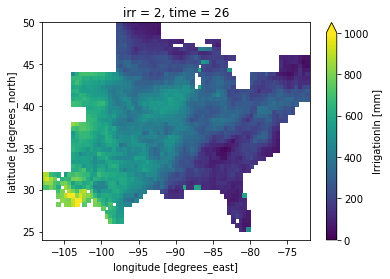

In [17]:
#use campaign nc file in run010
#use campaign file in created C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\data\campaign\created_campaign\test6 folder (this is the right one)
#for the following factor configuration:

#scen_new:0,irr:0 GS dry
#scen_new:1,irr:0 SS dry
#scen_new:2,irr:0 FSPS dry
#scen_new:3,irr:0 FS dry
#scen_new:0,irr:1 GS irrigated
#scen_new:1,irr:1 SS irrigated
#scen_new:2,irr:1 FSPS irrigated
#scen_new:3,irr:1 FS irrigated

df_final.IrrigationIn[25,3,1,0:,0:].plot(yincrease=True, x='lon', y='lat', vmin=0, vmax=1000)

# <font color='blue'>1- Arrange the multidimensional dataframe for the ENTIRE dataset (including crop failures)</font>

In [41]:
data1 = df_final.where(df_final['biomass'] != -99)
#data2 = data1.where(data1['biomass'] < 0)
#Create biomass variable in t ha-1
data1['biomass2'] = data1['biomass']/1000
# Remove values considered as crop failures < quantile(0.025)
#data4 = df_final.where(df_final['biomass'] > 5922.5) #df.biomass.quantile(0.025)

#Remove lat and lon combinations that were outside the study area. For this we need to convert the xarray to a 2D dataframe
#Conver multidimendional frame to 2D frame
data2 = data1.to_dataframe()
data2.reset_index(drop=False, inplace=True)
data=data2.replace(-99,np.nan).dropna(axis = 0, how = 'any')
df = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Maps\SorghumMask\OutsideAreas.csv')
coordinate_list = [list(row) for row in df.values]
dropSet = {tuple(elem) for elem in coordinate_list}

# Creates a multi-index on letter/colour.
temp = data.set_index(['lat', 'lon'])
# Keep all elements of the index except those in droplist.
temp = temp.loc[list(set(temp.index) - dropSet)]
# Reset index to get the original column layout.
df_dropped = temp.reset_index()

#Rename
df_dropped.rename(columns={'scen_new':'cultivar'}, inplace=True)
#df_dropped.set_index(['lat', 'lon', 'cultivar', 'irr','time'], inplace=True)

#Remove cells with 0% of cropland accordingly with AgMERRA dataset
landuse = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\landuse.csv')
data3 = pd.merge(landuse, df_dropped, how ='inner', on =['lat','lon']) 

#data2 = data3.drop(['rain_a_x','radn_a_x','rain_b_x','radn_b_x','rain_c_x','radn_c_x','wind_a_x','hur_a_x','hurtmax_a_x','cropland_a_x',
# 'tmax_a_x', 'tmin_a_x', 'tmean_a_x', 'wind_b_x', 'hur_b_x', 'hurtmax_b_x', 'cropland_b_x', 'tmax_b_x', 'tmin_b_x',
# 'tmean_b_x','wind_c_x', 'hur_c_x', 'hurtmax_c_x', 'cropland_c_x', 'tmax_c_x', 'tmin_c_x', 'tmean_c_x', 'radn_x',
# 'rain_x', 'tmin_x', 'tmax_x', 'tmean_x', 'wind_x', 'hur_x', 'hurtmax_x', 'env_x', 'rain_a_y', 'radn_a_y',
# 'rain_b_y', 'radn_b_y', 'rain_c_y', 'radn_c_y', 'wind_a_y', 'hur_a_y', 'hurtmax_a_y', 'cropland_a_y', 'tmax_a_y',
# 'tmin_a_y', 'tmean_a_y', 'wind_b_y', 'hur_b_y','hurtmax_b_y', 'cropland_b_y', 'tmax_b_y', 'tmin_b_y', 'tmean_b_y',
# 'wind_c_y', 'hur_c_y', 'hurtmax_c_y', 'cropland_c_y', 'tmax_c_y', 'tmin_c_y', 'tmean_c_y', 'radn_y', 'rain_y',
# 'tmin_y', 'tmax_y', 'tmean_y', 'wind_y', 'hur_y', 'hurtmax_y', 'cropland_y', 'env_y'], axis=1)

#Set index before to create the xarray
data5 = data3.set_index(['lat','lon','cultivar','irr','time'])

#From 2D dataframe to xarray
data4 = data5.to_xarray()
#remove data from West Virginia state which was out of bioenergy crop mask
#d1 = dataPre3.where(dataPre3.biomass != dataPre3.biomass[0:,0:,0:,52,24], drop=True)

### Conver multidimendional dataframe to 2D dataframe

In [42]:
data4pd = data4.to_dataframe()
dfc = data4pd[data4pd.biomass != 0]
dfc.reset_index(level=[0,1,2,3], inplace=True)
dfc.rename(columns={'scen_new':'cultivar'}, inplace=True)
df = dfc.dropna()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


### Remove `-99` values and calculate the quantile `0.025`

Note: for this study any value less than quantile 0.025 was considered a crop failure

In [43]:
df2 = df[df['biomass'] != -99]
df2.biomass.quantile(0.025)

5789.51259765625

In [9]:
# all_failures_spatial00 = all_failures_spatial0.reset_index()
# all_failures_spatial00.FailureRisk.max()
# all_failures_spatial00[all_failures_spatial00['FailureRisk'] > 80]

In [10]:
# mean_f = failures.groupby(['cultivar', 'irr'],as_index=False).count()
# mean_f 

In [11]:
# mean = df.groupby(['cultivar','irr','time'],as_index=False).count()
# mean

In [12]:
# df2.shape
# 93/309154*100

# <font color='blue'>2- Crop failure analysis before to do the general analysis</font>

Here a new dataframe is created to explore variables associated with the crop failures. The crop failure risk is calculated as the number of failures / 30 years.

In [51]:
df2 = df[df['sw80_harv'] != -99]
failures = df2[df2['biomass'] < 5789.0874]

mean_failures0 = failures.groupby(['lat', 'lon','cultivar','irr','RainIn','TempIn','aMinT','RadiationIn','ri0_40','ri40_80','ri80_harv','radHarv','aMaxT'],as_index=False).mean()
mean_failures = mean_failures0[['lat','lon','cultivar','irr','biomass2','RainIn','TempIn','aMinT','RadiationIn','ri0_40','ri40_80','ri80_harv','radHarv','aMaxT']]
count_failures0 = failures.groupby(['lat', 'lon','cultivar','irr'],as_index=False).count()
count_failures = count_failures0[['lat','lon','cultivar','irr','biomass2']]
count_failures.rename(columns={'biomass2':'NoFailures'}, inplace=True)
count_failures['years'] = 30

#Failure risk calculation
count_failures['FailureRisk'] = count_failures['NoFailures']/count_failures['years']*100
all_failures = pd.merge(mean_failures, count_failures, how ='inner', on =['lat','lon','irr','cultivar'])

#Write name of the genotypes
all_failures.loc[all_failures.cultivar == 0, 'cv'] = "GS"
all_failures.loc[all_failures.cultivar == 1, 'cv'] = "SS"
all_failures.loc[all_failures.cultivar == 2, 'cv'] = "PS"
all_failures.loc[all_failures.cultivar == 3, 'cv'] = "PI"

#Write names of the irrigation strategies
all_failures.loc[all_failures.irr == 1, 'irri'] = "R"
all_failures.loc[all_failures.irr == 2, 'irri'] = "I"

all_failures_spatial00 = all_failures.reset_index()
all_failures_spatial000 = all_failures_spatial00.drop(['index'], axis=1)
all_failures_spatial0000 = all_failures_spatial000.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#remove outliers in the irrigated database
all_failures_spatial2 = all_failures_spatial0000.drop(all_failures_spatial0000.index[[48,50,52,54,76,78,80,82,195,200,358,360,362]])
all_failures_spatial0 = all_failures_spatial2.set_index(['lat','lon','cultivar','irr'])
all_failures_spatial = all_failures_spatial0.to_xarray()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-51-acf677e03cae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_failures['years'] = 30
<ipython-input-51-acf677e03cae>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

### Explore 2D dataframe of crop failures

In [52]:
all_failures_spatial0.head()

biomass2      RainIn  TempIn      aMinT  \
lat   lon    cultivar irr                                            
26.25 -98.25 0        1      4.9679  106.449997  30.142  24.070999   
             1        1      4.9880  106.449997  30.142  24.070999   
             2        1      4.7977  106.449997  30.142  24.070999   
             3        1      5.0712  106.449997  30.142  24.070999   
      -97.75 0        1      1.6714  209.574997  30.146  25.256001   

                           RadiationIn  ri0_40     ri40_80   ri80_harv  \
lat   lon    cultivar irr                                                
26.25 -98.25 0        1    2756.195068     0.0  199.925003  727.064026   
             1        1    2756.195068     0.0  118.871002  720.172974   
             2        1    2756.195068     0.0   13.729000  571.288025   
             3        1    2756.195068     0.0  170.710999  695.450012   
      -97.75 0        1    2739.600098     0.0    0.000000  132.468002   

                              radHarv      aMaxT  NoFailures  years  \
lat   lon    cultivar irr                                             
26.25 -98.25 0        1    817.122009  36.213001           3     30   
             1        1    817.122009  36.213001           3     30   
             2        1    817.122009  36.213001           3     30   
             3        1    817.122009  36.213001           2     30   
      -97.75 0        1    771.952026  35.035000           2     30   

                           FailureRisk  cv irri  
lat   lon    cultivar irr                        
26.25 -98.25 0        1      10.000000  GS    R  
             1        1      10.000000  SS    R  
             2        1      10.000000  PS    R  
             3        1       6.666667  PI    R  
      -97.75 0        1       6.666667  GS    R

### Explore multidimensional dataframe of crop failures with xarray

In [53]:
all_failures_spatial

<xarray.Dataset>
Dimensions:      (cultivar: 4, irr: 2, lat: 43, lon: 64)
Coordinates:
  * lat          (lat) float64 26.25 26.75 28.75 29.25 ... 47.75 48.25 48.75
  * lon          (lon) float64 -103.8 -103.2 -102.8 ... -73.25 -72.75 -72.25
  * cultivar     (cultivar) int64 0 1 2 3
  * irr          (irr) int64 1 2
Data variables:
    biomass2     (lat, lon, cultivar, irr) float32 nan nan nan ... nan nan nan
    RainIn       (lat, lon, cultivar, irr) float64 nan nan nan ... nan nan nan
    TempIn       (lat, lon, cultivar, irr) float64 nan nan nan ... nan nan nan
    aMinT        (lat, lon, cultivar, irr) float64 nan nan nan ... nan nan nan
    RadiationIn  (lat, lon, cultivar, irr) float64 nan nan nan ... nan nan nan
    ri0_40       (lat, lon, cultivar, irr) float64 nan nan nan ... nan nan nan
    ri40_80      (lat, lon, cultivar, irr) float64 nan nan nan ... nan nan nan
    ri80_harv    (lat, lon, cultivar, irr) float64 nan nan nan ... nan nan nan
    radHarv      (lat, lon, cultivar, irr) float64 nan nan nan ... nan nan nan
    aMaxT        (lat, lon, cultivar, irr) float64 nan nan nan ... nan nan nan
    NoFailures   (lat, lon, cultivar, irr) float64 nan nan nan ... nan nan nan
    years        (lat, lon, cultivar, irr) float64 nan nan nan ... nan nan nan
    FailureRisk  (lat, lon, cultivar, irr) float64 nan nan nan ... nan nan nan
    cv           (lat, lon, cultivar, irr) object nan nan nan ... nan nan nan
    irri         (lat, lon, cultivar, irr) object nan nan nan ... nan nan nan

In [55]:
#all_failures_spatial2 = all_failures_spatial0.reset_index()
#all_failures_spatial2.loc[(all_failures_spatial2['irri'] == 'I') & (all_failures_spatial2['lat'] < 37)]

### Export failures as nc4 file (optional)

In [ ]:
#all_failures_spatial.to_netcdf(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Maps\Failures\failures.nc4')

### Map crop failures by irrigation strategy and genotype across the US

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-56-f89174b34f04>:119: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


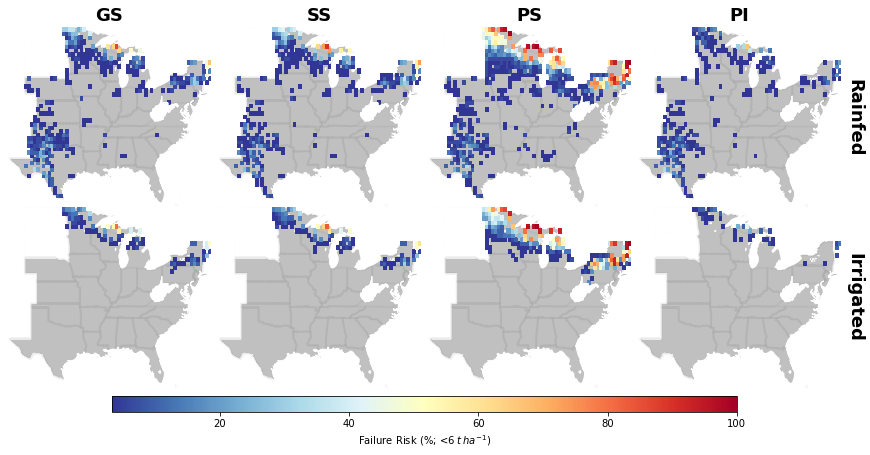

In [56]:
map_proj = ccrs.Mercator(central_longitude=-95)

p = all_failures_spatial.FailureRisk.plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj},
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu_r,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=5, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1, linewidth =0, edgecolor =None,
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =1, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =1, edgecolor = "white",
                                  label=n.attributes['postal'])
    return ax

iso4 = ['NM','CO','WY','ND','SD','MT','VT','NH','MA','RI','CT']

def area3(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =0.5, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =0.5, edgecolor = "white",
                                  label=n.attributes['postal'])
    return ax

iso5 = ['WV']

def area4(ax, iso, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor='silver', zorder=z,
                                  alpha = 1.00, linewidth =0.5, edgecolor = "grey",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor='silver',
                                  alpha = 0.1, linewidth =2, edgecolor = "grey",
                                  label=n.attributes['postal'])
    return ax

iso6 = ['TX','OK','KS','NE','IA','MN','WI','OH','PA','NY',
        'NC','SC','GA','FL','AL','MS','LA','AR','MO','IL','IN','KY','TN','NJ']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("PS", fontsize=18, fontweight="bold")    
axes[3].set_title("PI", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=0.5,zorder=1)
    ax.add_feature(cfeature.STATES, edgecolor = "grey", linewidth=0.5, zorder=1, color='silver')
    ax.add_feature(cfeature.OCEAN, color='white',edgecolor = "grey", zorder=2)
    ax.add_feature(cfeature.LAKES, color='white',edgecolor = "grey", linewidth=0.5, zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", linewidth=0.2)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")
    
    for value in iso5 :
        area3(ax, value, "white", 6)

    area3(ax, value, "white", 6)
    
    for value in iso6 :
        area4(ax, value, 1)

    area4(ax, value, 1)

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.2, hspace=0)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='Failure Risk (%; <6 $t\,ha^{-1}$)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\NoFailures.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot Biomass vs Minimum Temperature for irrigated and rainfed treatment
To do this graph is needed to read a csv file (`dfenv2.csv`) with the clustered environments to use it for the point colors

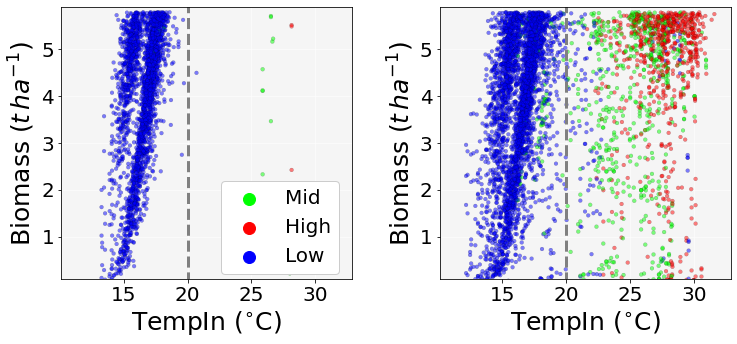

In [15]:
#Read dataframe with env names
X= pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\dfenv2.csv')

color_dict = dict({'High': '#ff0101','Mid':'#00ff01','Low':'#0000fe'})

#Merge current dataset to include envs
new = pd.merge(X, all_failures, how ='inner', on =['lat','lon']) 

dry = new[new['irri'] == 'R']
irri = new[new['irri'] == 'I']

kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(12,5))

ax=plt.subplot(1, 2, 1)
sns.scatterplot(x="TempIn_y", y="biomass2",hue='env_name', alpha=0.5, data=irri, linewidth=0.2,**kwargs,s=15, palette=color_dict)

# Formatting graph and background
plt.legend(prop=dict(size=20),bbox_to_anchor=(0.55, 0.36), loc=2, borderaxespad=0., ncol=1,framealpha=1,markerscale=2)
plt.ylabel('Biomass ($t\,ha^{-1}$)', fontsize =25)
plt.xlabel('TempIn ($^{\circ}$C)', fontsize =25)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([10.1,32.9])
ax.set_ylim([0.1,5.9])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()
#ax.set_title('a',fontsize= 30,weight='bold')
plt.plot([20,20],[0,6],"--",color="grey", linewidth=3,zorder=1)

ax=plt.subplot(1, 2, 2)

sns.scatterplot(x="TempIn_y", y="biomass2", hue='env_name', alpha=0.5, data=dry, linewidth=0.2,**kwargs,s=15, palette=color_dict)

# Formatting graph and background
plt.legend(prop=dict(size=12),bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., ncol=1,framealpha=1,markerscale=2)
plt.ylabel('Biomass ($t\,ha^{-1}$)', fontsize =25)
plt.xlabel('TempIn ($^{\circ}$C)', fontsize =25)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([10.1,32.9])
ax.set_ylim([0.1,5.9])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()
#ax.set_title('b',fontsize= 30,weight='bold') 
plt.plot([20,20],[0,6],"--",color="grey", linewidth=3,zorder=1)

# ax=plt.subplot(1, 3, 3)
# temp = dry[dry['TempIn'] > 20]
# kwargs  =   {'edgecolor':"k"}
# sns.scatterplot(x="ri80_harv", y="biomass2",hue='cv', alpha=0.7, data=temp, linewidth=0.2,**kwargs,s=50, palette='Set1')

# # Formatting graph and background
# plt.legend(prop=dict(size=13.5),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=1,framealpha=0.3,markerscale=2)
# plt.ylabel('Biomass ($t\,ha^{-1}$)', fontsize =18)
# plt.xlabel('IRad 80-Harvest ($MJ\,m^{-2}$)', fontsize =18)
# ax = plt.gca()
# ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
# ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
# ax.patch.set_facecolor('0.96')
# ax.set_axisbelow(True)
# ax.yaxis.set_tick_params(labelsize=15)
# ax.xaxis.set_tick_params(labelsize=15)
# #ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# #ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
# #ax.set_xlim([9.9,34.9])
# #ax.set_ylim([100.1,159.9])
# plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
# plt.tick_params(axis='y',which='both',left=True)
# #ax.get_legend().remove()
# ax.set_title('c',fontsize= 30,weight='bold') 
####################################################################
plt.subplots_adjust(wspace=0.3, hspace=0)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\Failures.png', dpi=600, bbox_inches='tight', pad_inches=0)

### Calculate the percentage of failures per environment

In [18]:
#Change the name of the environment to get the value per env
new[new['env_name'] == 'Mid'].shape

(701, 101)

In [19]:
701/7728*100

9.070910973084887

### Plot Biomass vs intercepted radiation from 80DAS to harvest

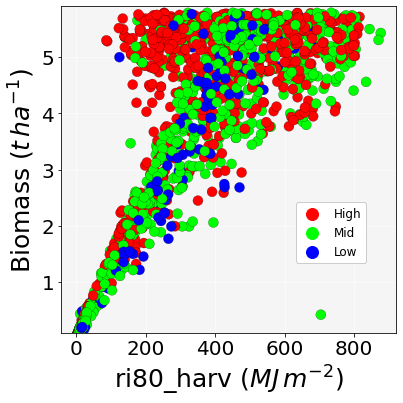

In [236]:
# 'ESW1av', 'FloweringDAS', 'IrrigationIn', 'N_stress_expan',
#        'N_stress_photo', 'PAWC', 'WU', 'actual_ET', 'biomass', 'planting_date',
#        'potential_ET', 'rad40DAS', 'rad80DAS', 'rain40DAS',
#        'rain80DAS', 'rainHarv','sw0_40', 'sw40_80', 'sw80_harv', 'sw_stress_expan', 'sw_stress_photo',
#        'temp40DAS', 'temp80DAS', 'tempHarv', 'tp0_40', 'tp40_80', 'tp80_harv',
#        'env', 'env_name', 'RainIn_y', 'TempIn_y', 'aMinT_y', 'RadiationIn_y',
#        'ri0_40_y', 'ri40_80_y', 'ri80_harv_y', 'radHarv_y', 'aMaxT_y',
#        'NoFailures', 'years', 'FailureRisk', 'cv', 'irri'],

dry_19 = dry[dry['TempIn_y'] > 20]
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(6,6))

ax=plt.subplot(1, 1, 1)
sns.scatterplot(x="ri80_harv_y", y="biomass2", hue='env_name', alpha=1, data=dry_19, linewidth=0.2,**kwargs,s=100, palette=color_dict)

# Formatting graph and background
plt.legend(prop=dict(size=12),bbox_to_anchor=(0.7, 0.4), loc=2, borderaxespad=0., ncol=1,framealpha=1,markerscale=2)
plt.ylabel('Biomass ($t\,ha^{-1}$)', fontsize =25)
plt.xlabel('ri80_harv ($MJ\,m^{-2}$)', fontsize =25)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.set_xlim([10.1,32.9])
ax.set_ylim([0.1,5.9])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()
#ax.set_title('b',fontsize= 30,weight='bold') 

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\fre2.png', dpi=600, bbox_inches='tight', pad_inches=0)

### Plot Frequency of data for irrigated and rainfed biomass

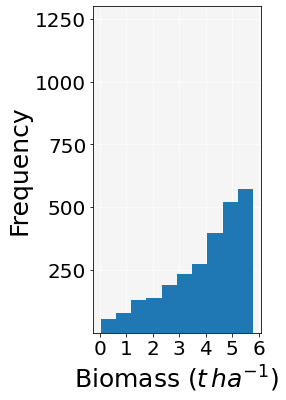

In [133]:
dry0 = failures[failures['irr'] == 1]
irri0 = failures[failures['irr'] == 2]

kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(3,6))

ax=plt.subplot(1, 1, 1)
irri0.biomass2.plot.hist()

# Formatting graph and background
plt.legend(prop=dict(size=20),bbox_to_anchor=(1, 0.47), loc=2, borderaxespad=0., ncol=1,framealpha=1,markerscale=2)
plt.ylabel('Frequency', fontsize =25)
plt.xlabel('Biomass ($t\,ha^{-1}$)', fontsize =25)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(250))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylim([0.1,1299])
ax.get_legend().remove()
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\fre2.png', dpi=600, bbox_inches='tight', pad_inches=0)

# <font color='blue'>3- Working with clean dataset without failures</font>

Here two csv files are required:
* `OutsideAreas.csv` = outside areas of the map
* `landuse.csv` = gris cells with more than 0% of cropland

In [57]:
data1 = df_final.where(df_final['biomass'] != -99)
data2 = data1.where(data1['biomass'] > 5789.0874) # removing failures #df.biomass.quantile(0.025)
#Create biomass variable in t ha-1
data2['biomass2'] = data2['biomass']/1000
#Remove lat and lon combinations that were outside the study area. For this we need to convert the xarray to a 2D dataframe
#Conver multidimendional frame to 2D frame
data3 = data2.to_dataframe()
data3.reset_index(drop=False, inplace=True)
data=data3.replace(-99,np.nan).dropna(axis = 0, how = 'any')
#clean outside areas of the map
df = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Maps\SorghumMask\OutsideAreas.csv')
coordinate_list = [list(row) for row in df.values]
dropSet = {tuple(elem) for elem in coordinate_list}

# Creates a multi-index on letter/colour.
temp = data.set_index(['lat', 'lon'])
# Keep all elements of the index except those in droplist.
temp = temp.loc[list(set(temp.index) - dropSet)]
# Reset index to get the original column layout.
df_dropped = temp.reset_index()

#Rename
df_dropped.rename(columns={'scen_new':'cultivar'}, inplace=True)
#df_dropped.set_index(['lat', 'lon', 'cultivar', 'irr','time'], inplace=True)

#Remove cells with 0% of cropland accordingly with AgMERRA dataset
landuse = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\landuse.csv')
data3 = pd.merge(landuse, df_dropped, how ='inner', on =['lat','lon']) 

#data2 = data3.drop(['rain_a_x','radn_a_x','rain_b_x','radn_b_x','rain_c_x','radn_c_x','wind_a_x','hur_a_x','hurtmax_a_x','cropland_a_x',
# 'tmax_a_x', 'tmin_a_x', 'tmean_a_x', 'wind_b_x', 'hur_b_x', 'hurtmax_b_x', 'cropland_b_x', 'tmax_b_x', 'tmin_b_x',
# 'tmean_b_x','wind_c_x', 'hur_c_x', 'hurtmax_c_x', 'cropland_c_x', 'tmax_c_x', 'tmin_c_x', 'tmean_c_x', 'radn_x',
# 'rain_x', 'tmin_x', 'tmax_x', 'tmean_x', 'wind_x', 'hur_x', 'hurtmax_x', 'env_x', 'rain_a_y', 'radn_a_y',
# 'rain_b_y', 'radn_b_y', 'rain_c_y', 'radn_c_y', 'wind_a_y', 'hur_a_y', 'hurtmax_a_y', 'cropland_a_y', 'tmax_a_y',
# 'tmin_a_y', 'tmean_a_y', 'wind_b_y', 'hur_b_y','hurtmax_b_y', 'cropland_b_y', 'tmax_b_y', 'tmin_b_y', 'tmean_b_y',
# 'wind_c_y', 'hur_c_y', 'hurtmax_c_y', 'cropland_c_y', 'tmax_c_y', 'tmin_c_y', 'tmean_c_y', 'radn_y', 'rain_y',
# 'tmin_y', 'tmax_y', 'tmean_y', 'wind_y', 'hur_y', 'hurtmax_y', 'cropland_y', 'env_y'], axis=1)

#Set index before to create the xarray
data5 = data3.set_index(['lat','lon','cultivar','irr','time'])

#From 2D dataframe to xarray
data4 = data5.to_xarray()
#remove data from West Virginia state which was out of bioenergy crop mask
#d1 = dataPre3.where(dataPre3.biomass != dataPre3.biomass[0:,0:,0:,52,24], drop=True)

### Conver multidimendional frame to 2D frame

In [58]:
data4pd = data4.to_dataframe()
dfc = data4pd[data4pd.biomass != 0]
dfc.reset_index(level=[0,1,2,3], inplace=True)
dfc.rename(columns={'scen_new':'cultivar'}, inplace=True)
df = dfc.dropna()

### Plot planting dates by irrigation treatment
For this study, we set up in pAPSIM a variable planting rule based on the median corn planting date, air mean temperature and rainfall. The USDA Corn Crop Progress Maps are gridded geospatial weekly datasets (9 km resolution) which are fully synthetic representations of confidential, county corn planting dates. We used the 2020 USDA Corn Crop Progress Map to estimate the planting date windows for sorghum at 30 arc-minute resolution in the study region. A sorghum window planting date from 15 to 45 days after the median corn planting date was applied for both irrigation strategies. The planting was executed when the average air temperature was, at least, 11°C for 7 consecutively days. Under rainfed conditions, there was also a rainfall requirement of, at least, 30 mm of cumulative rainfall during 14 consecutively days to sow the crop.

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


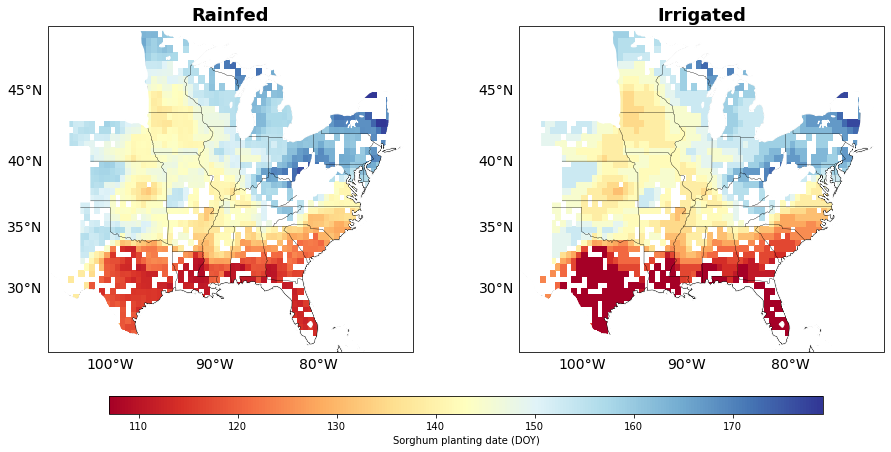

In [253]:
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.DOY.mean(dim=('time','cultivar'), skipna=True).plot(x='lon', y='lat', col='irr',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, #=a.biomass2.min(),vmax=a.biomass2.max(),
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("Rainfed", fontsize=18, fontweight="bold")
axes[1].set_title("Irrigated", fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=True,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "k", linewidth=2)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "k", color='k', linewidth=2)
    ax.set_extent([-106, -71, 24.5, 49.2], crs=ccrs.PlateCarree())
    gl.xlabels_top = False
    gl.ylabels_right = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'color': 'k'}
    gl.ylabel_style = {'size': 14, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#    gl.top_labels = False
#    gl.left_labels = True
#    gl.right_labels =False
#    gl.xlines = False
#    gl.ylines = False
    gl.xlocator = mticker.FixedLocator([-100,-90, -80, -70]) #
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45]) #
#    gl.xformatter = LONGITUDE_FORMATTER
#    gl.yformatter = LATITUDE_FORMATTER
#    gl.xlabel_style = {'size': 10, 'color': 'k'}
#    gl.ylabel_style = {'size': 10, 'color': 'k'}

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.12, hspace=0.15)
p.add_colorbar(orientation='horizontal', pad=0.1, shrink=0.8, aspect=40, label='Sorghum planting date (DOY)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\mean_biomass0.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot average cumulative rainfal during the growing season
The values in each grid are means across genotypes, irrigation and years.

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-259-e467f0cc7d38>:77: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


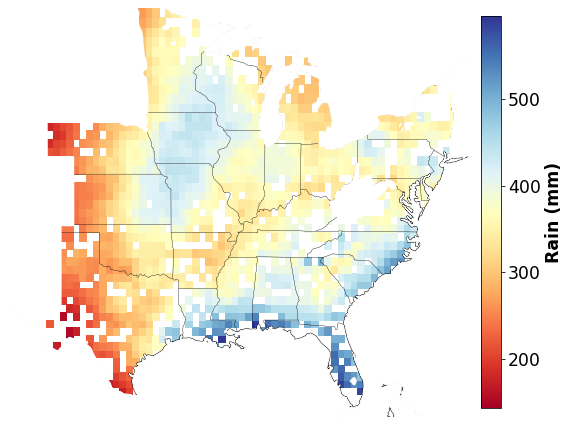

In [259]:
a = df.groupby(['lat', 'lon'],as_index=False).mean()
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

p=data4.RainIn.mean(dim=('time','cultivar','irr'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.RdYlBu, add_colorbar=False, zorder=1, vmin=a.RainIn.quantile(0), vmax=a.RainIn.quantile(1))

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =1, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =3, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "k", linewidth=2)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "white", color='white', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='Rain (mm)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\rain.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot average cumulative radiation during the growing season
The values in each grid are means across genotypes, irrigation and years.

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-260-652984902548>:77: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


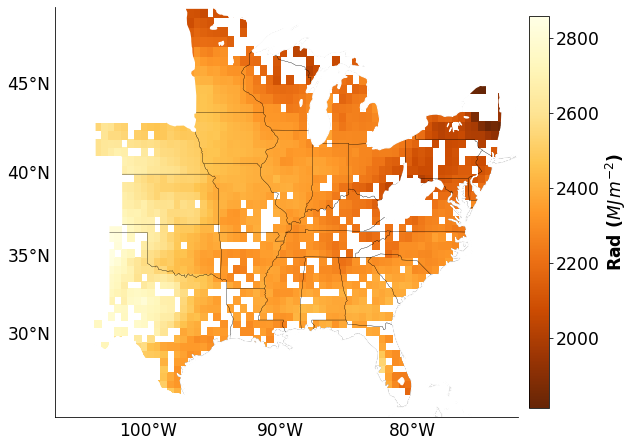

In [260]:
a = df.groupby(['lat', 'lon'],as_index=False).mean()
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

p=data4.RadiationIn.mean(dim=('time','cultivar','irr'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.YlOrBr_r, add_colorbar=False, zorder=1, vmin=a.RadiationIn.quantile(0), vmax=a.RadiationIn.quantile(1))

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=True,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "white", color='white', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 17, 'color': 'k'}
gl.ylabel_style = {'size': 17, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='Rad ($MJ\,m^{-2}$)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

ax.outline_patch.set_visible(False)
ax.spines['left'].set_visible(True)  
ax.spines['bottom'].set_visible(True)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\rad.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot daily mean temperature during the growing season
The values in each grid are means across genotypes, irrigation and years.

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-262-9058ba2c6802>:77: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


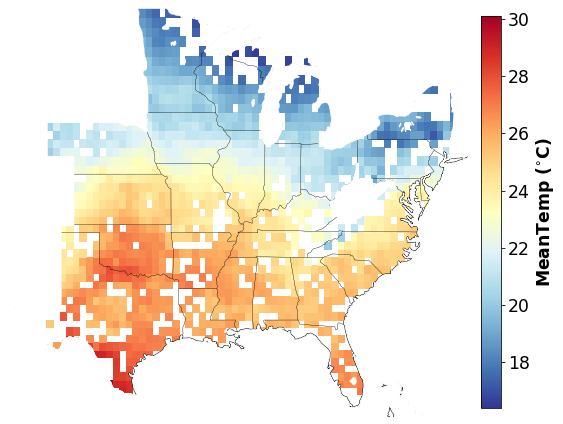

In [262]:
a = df.groupby(['lat', 'lon'],as_index=False).mean()
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

p=data4.TempIn.mean(dim=('time','cultivar','irr'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.RdYlBu_r, zorder=1, add_colorbar=False, vmin=a.TempIn.quantile(0), vmax=a.TempIn.quantile(1))

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "k", linewidth=2)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "k", color='k', linewidth=2)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='MeanTemp ($^{\circ}$C)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\temp.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot ir, tp and sw

The clustering was applied using the sum of intercepted solar radiation (ir), mean of temperature stress factor (tp) and mean of water stress factor (sw).
These maps were created using only dryland environments to calculate factors of stress (in the coding is `irri`=1)

In [60]:
data5 = data4.where(data4['irr'] == 1)
#The following code is to determine the min and max of each variable. It need to be run after the map.
#a.ri40_80.max()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-62-744ff3a8f7ed>:76: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


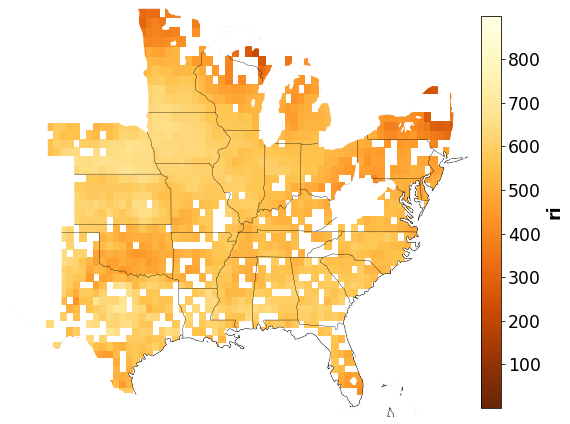

In [62]:
a = df.groupby(['lat', 'lon'],as_index=False).mean()
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

p=data5.ri80_harv.mean(dim=('time','cultivar','irr'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.YlOrBr_r, zorder=1, add_colorbar=False,vmin=0.1, vmax=899)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "k", linewidth=2)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "k", color='k', linewidth=2)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='ri', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\sw.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot multipanels by year (example for radiation)
`year 1`=1980, `year 30`=2009

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-63-48877ce80b86>:60: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


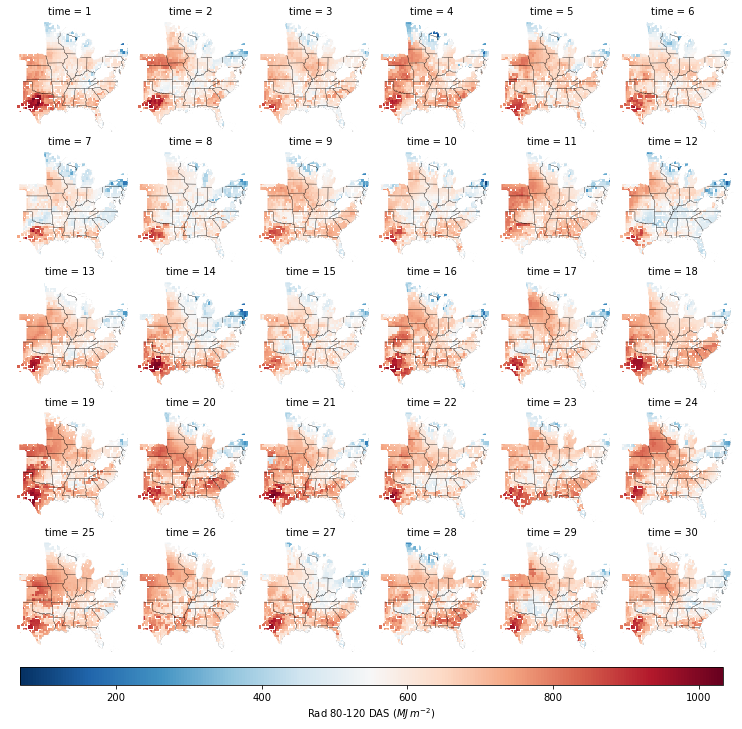

In [63]:
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.radHarv.mean(dim=('irr','cultivar'), skipna=True).plot(x='lon', y='lat',col='time', col_wrap=6,
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj},
    figsize=(18,14),
    cmap=mpl.cm.RdBu_r,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.7, hspace=0.17)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='Rad 80-120 DAS ($MJ\,m^{-2}$)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\rad80-120.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-64-c25847c03f31>:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


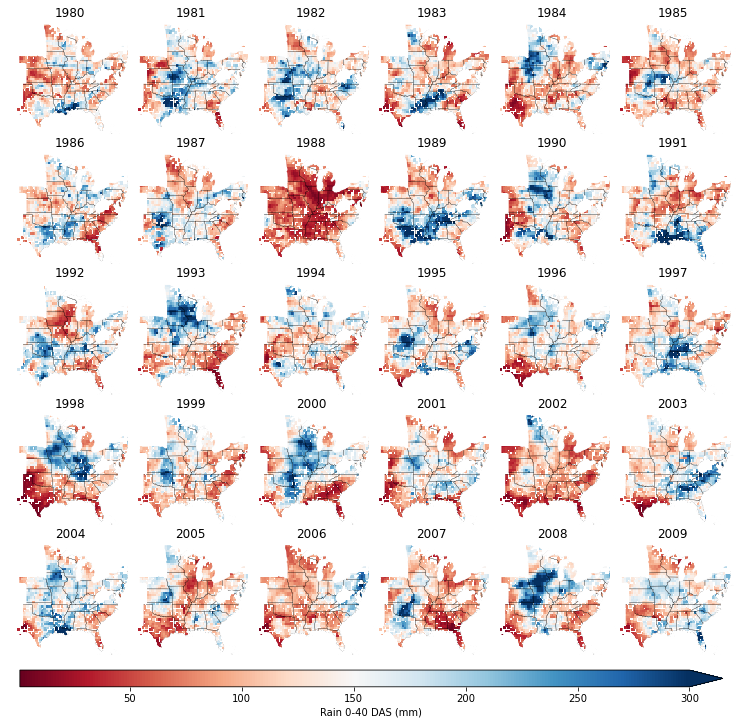

In [64]:
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.rain40DAS.mean(dim=('cultivar','irr'), skipna=True).plot(x='lon', y='lat', col='time', col_wrap=6,
    transform=ccrs.PlateCarree(central_longitude=0), vmax=300,
    subplot_kws={'projection': map_proj},
    figsize=(18,14),
    cmap=mpl.cm.RdBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("1980", fontsize=12)
axes[1].set_title("1981", fontsize=12)
axes[2].set_title("1982", fontsize=12)    
axes[3].set_title("1983", fontsize=12)
axes[4].set_title("1984", fontsize=12)
axes[5].set_title("1985", fontsize=12)
axes[6].set_title("1986", fontsize=12)
axes[7].set_title("1987", fontsize=12)
axes[8].set_title("1988", fontsize=12)
axes[9].set_title("1989", fontsize=12)
axes[10].set_title("1990", fontsize=12)
axes[11].set_title("1991", fontsize=12)
axes[12].set_title("1992", fontsize=12)
axes[13].set_title("1993", fontsize=12)
axes[14].set_title("1994", fontsize=12)
axes[15].set_title("1995", fontsize=12)
axes[16].set_title("1996", fontsize=12)
axes[17].set_title("1997", fontsize=12)
axes[18].set_title("1998", fontsize=12)
axes[19].set_title("1999", fontsize=12)
axes[20].set_title("2000", fontsize=12)
axes[21].set_title("2001", fontsize=12)
axes[22].set_title("2002", fontsize=12)
axes[23].set_title("2003", fontsize=12)
axes[24].set_title("2004", fontsize=12)
axes[25].set_title("2005", fontsize=12)
axes[26].set_title("2006", fontsize=12)
axes[27].set_title("2007", fontsize=12)
axes[28].set_title("2008", fontsize=12)
axes[29].set_title("2009", fontsize=12)

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.7, hspace=0.17)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='Rain 0-40 DAS (mm)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\rad80-120.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot Plant Available Water Capacity (PAWC)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-8-a50481eac153>:77: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


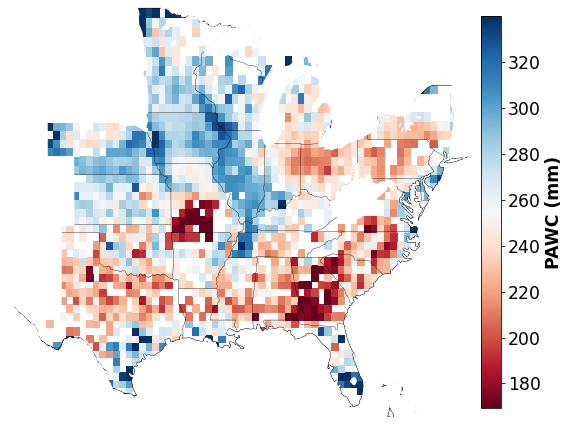

In [8]:
a = df.groupby(['lat', 'lon'],as_index=False).mean()
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

p=data4.PAWC.mean(dim=('time','cultivar','irr'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.RdBu, zorder=1, add_colorbar=False) #vmin=a.TempIn.quantile(0), vmax=a.TempIn.quantile(1))

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =1, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "k", linewidth=2)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "k", color='k', linewidth=2)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='PAWC (mm)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\pawc.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot mean biomass by irrigation and genotype

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-65-39394c16b53b>:74: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


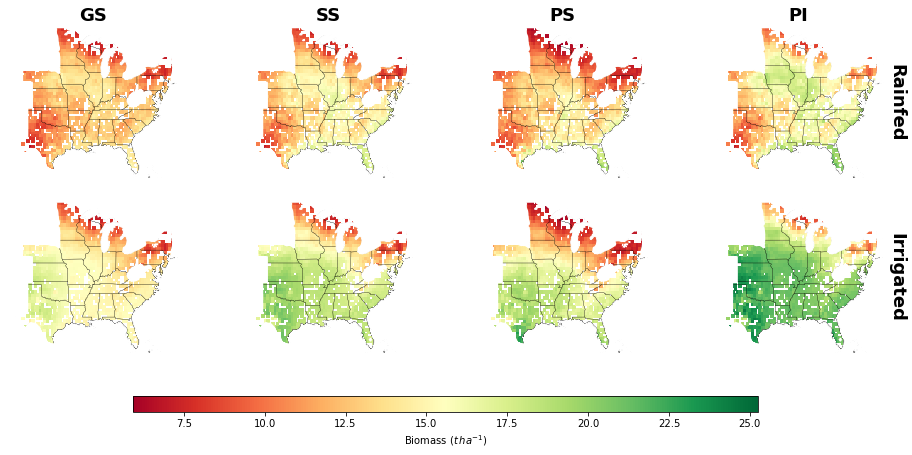

In [65]:
#Plotting mean biomass
a = df.groupby(['lat', 'lon','cultivar','irr'],as_index=False).mean()
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.biomass2.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, #=a.biomass2.min(),vmax=a.biomass2.max(),
    figsize=(16,8),
    cmap=mpl.cm.RdYlGn,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("PS", fontsize=18, fontweight="bold")    
axes[3].set_title("PI", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "k", linewidth=1.5)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "k", color='k', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#    gl.top_labels = False
#    gl.left_labels = True
#    gl.right_labels =False
#    gl.xlines = False
#    gl.ylines = False
#    gl.xlocator = mticker.FixedLocator([]) #-120, -100, -80
#    gl.ylocator = mticker.FixedLocator([]) #25, 35, 45
#    gl.xformatter = LONGITUDE_FORMATTER
#    gl.yformatter = LATITUDE_FORMATTER
#    gl.xlabel_style = {'size': 10, 'color': 'k'}
#    gl.ylabel_style = {'size': 10, 'color': 'k'}

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.25, hspace=0.15)
p.add_colorbar(orientation='horizontal', pad=0.1, shrink=0.7, aspect=40, label='Biomass ($t\,ha^{-1}$)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\mean_biomass0.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot standard deviation of biomass

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-66-a928c901c44c>:73: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


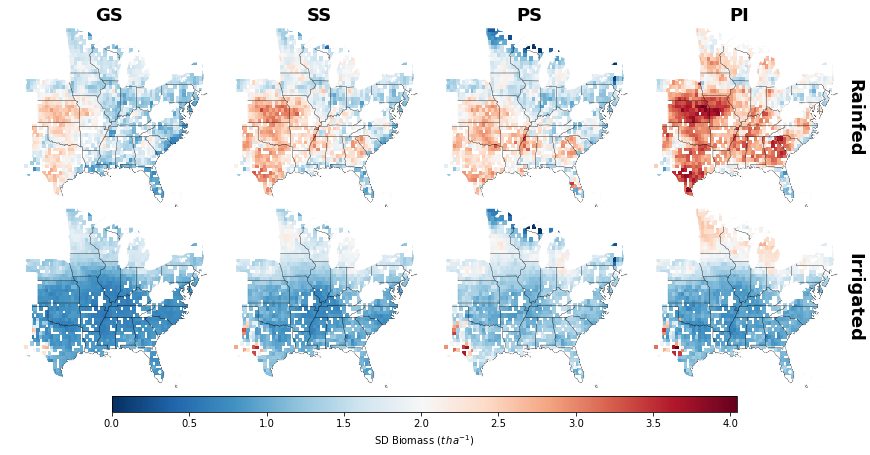

In [66]:
a = df.groupby(['lat', 'lon','cultivar','irr'],as_index=False).std()
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.biomass2.std(dim=('time'), skipna=True).plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, #vmin=a.biomass2.quantile(0.001),vmax=a.biomass2.quantile(0.999),
    figsize=(16,8), #rasterized=True,
    cmap=mpl.cm.RdBu_r,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("PS", fontsize=18, fontweight="bold")    
axes[3].set_title("PI", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "k", linewidth=1.5)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "k", color='k', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")
    
#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.2, hspace=0)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='SD Biomass ($t\,ha^{-1}$)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\sd_biomass.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot the sum of years when the crop did not fail

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-67-c246d6b616df>:73: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


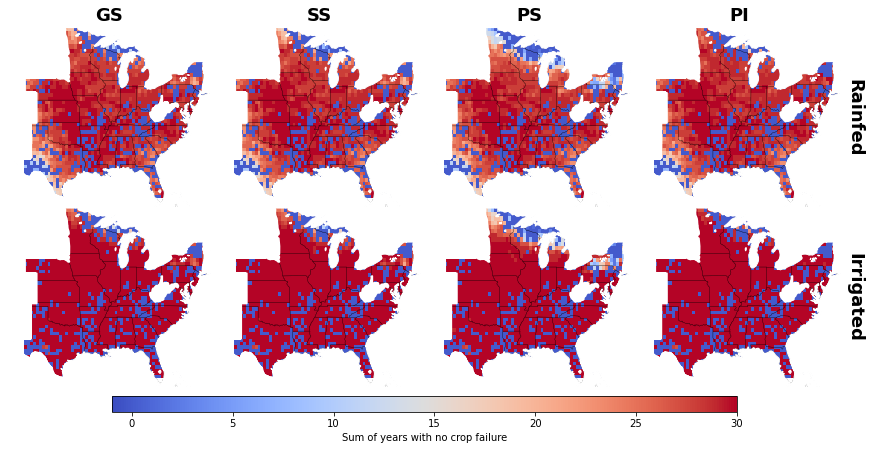

In [67]:
a = df.groupby(['lat', 'lon','cultivar','irr'],as_index=False).count()
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.biomass2.count(dim=('time')).plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1,vmax=30,
    figsize=(16,8),
    cmap=mpl.cm.coolwarm,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("PS", fontsize=18, fontweight="bold")    
axes[3].set_title("PI", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.2, hspace=0)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='Sum of years with no crop failure')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\failures.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot the crop cycle length (DAS)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-68-4261cfa99011>:73: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


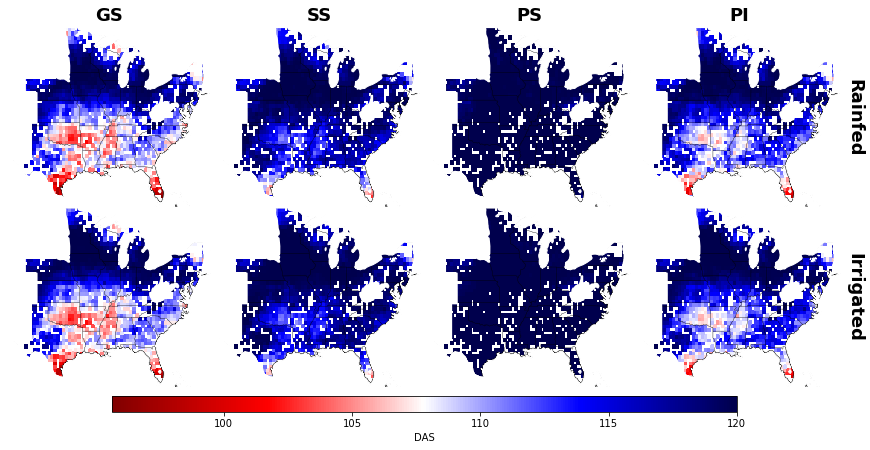

In [68]:
a = df.groupby(['lat', 'lon','cultivar','irr'],as_index=False).mean()
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.DaysAfterSowing.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=a.DaysAfterSowing.min(),vmax=a.DaysAfterSowing.max(),
    figsize=(16,8),
    cmap=mpl.cm.seismic_r,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("PS", fontsize=18, fontweight="bold")    
axes[3].set_title("PI", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "k", linewidth=2)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "k", color='k', linewidth=2)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.2, hspace=0)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='DAS')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\DAS.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot the flowering date (DAS)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-301-6d3af15df981>:74: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


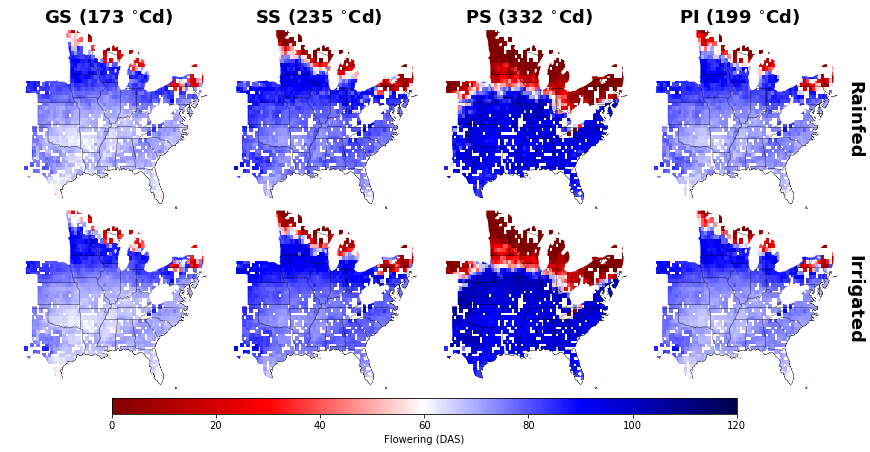

In [301]:
a = df.groupby(['lat', 'lon','cultivar','irr'],as_index=False).mean()
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.FloweringDAS.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=0,vmax=120,
    figsize=(16,8),
    cmap=mpl.cm.seismic_r,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS (173 $^{\circ}$Cd)", fontsize=18, fontweight="bold")
axes[1].set_title("SS (235 $^{\circ}$Cd)", fontsize=18, fontweight="bold")
axes[2].set_title("PS (332 $^{\circ}$Cd)", fontsize=18, fontweight="bold")    
axes[3].set_title("PI (199 $^{\circ}$Cd)", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "k", linewidth=2)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "k", color='k', linewidth=2)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.2, hspace=0)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='Flowering (DAS)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\Flowering.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot the irrigation applied during the growing season (`IrrigationIn`)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-100-97554fc51c9a>:74: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


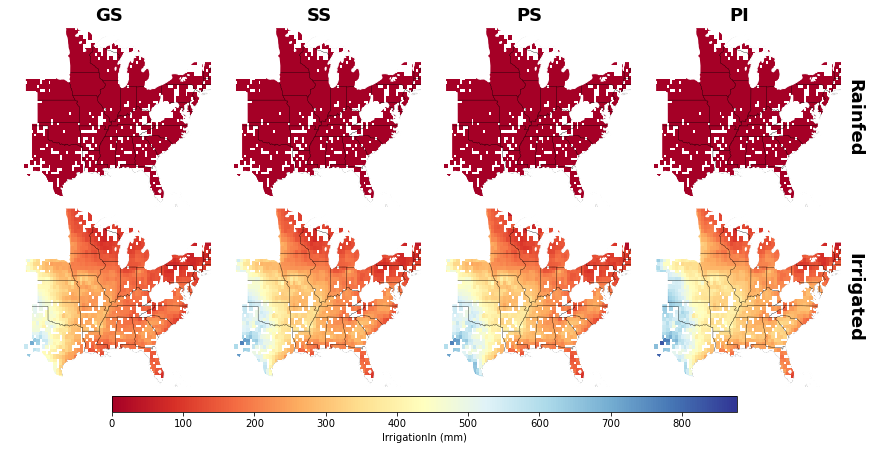

In [100]:
a = df.groupby(['lat', 'lon','cultivar','irr'],as_index=False).mean()
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.IrrigationIn.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj},
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "IrrigationIn (mm)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("PS", fontsize=18, fontweight="bold")    
axes[3].set_title("PI", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.2, hspace=0)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='IrrigationIn (mm)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\IrrigationIn.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

# <font color='blue'>4- Work with 2D pandas dataframe and correlations</font>

### Conver multidimendional frame to 2D frame

In [69]:
data4pd = data4.to_dataframe()
df = data4pd[data4pd.biomass != 0]
df.reset_index(level=[0,1,2,3,4], inplace=True)
#Change name of column
df.rename(columns={'scen_new':'cultivar'}, inplace=True)

### Calculate correlation between defined variables (specify `x` and `y` variable!)
In the following map is the plot of correlations between cumulative rainfall during the growing season (`RainIn`) and biomass

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-70-1e555dadb3cb>:96: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


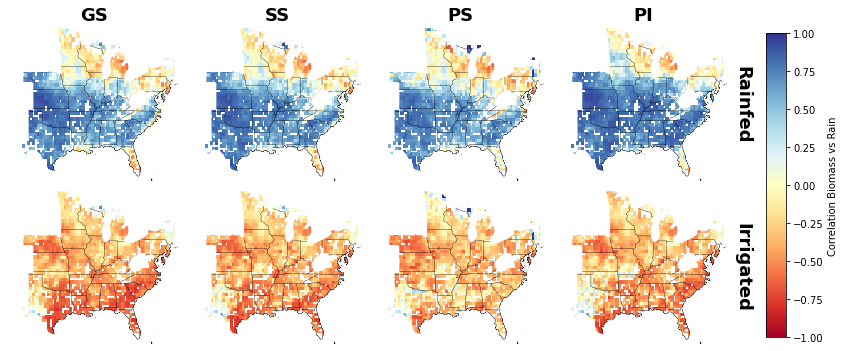

In [70]:
y='RainIn'
x='biomass'

#Set index
dfa = df.set_index(['lat','lon','cultivar','irr'])

a=dfa.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4','biomass'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.RainIn.plot(x='lon', y='lat', col='cultivar', row='irr', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("PS", fontsize=18, fontweight="bold")    
axes[3].set_title("PI", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "k", linewidth=2)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "k", color='k', linewidth=2)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")
    
#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.05, hspace=-0.4)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=15, label='Correlation Biomass vs Rain')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\raincorr.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot correlation between mean temperature (`TempIn`) and biomass

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-71-147e35a4a200>:97: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


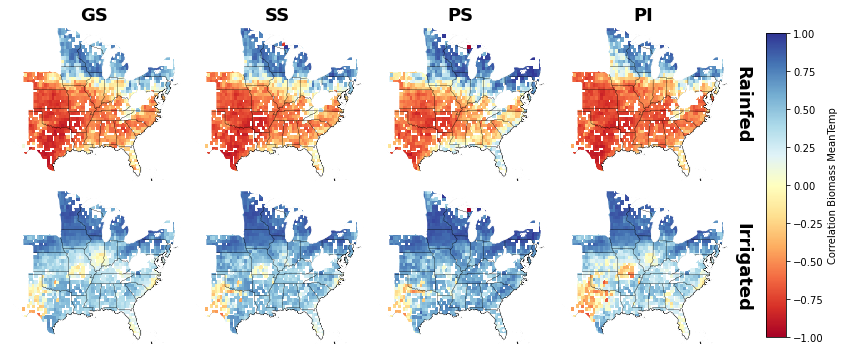

In [71]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='TempIn'
x='biomass'

#Set index
dfa = df.set_index(['lat','lon','cultivar','irr'])

a=dfa.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4','biomass'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.TempIn.plot(x='lon', y='lat', col='cultivar', row='irr', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("PS", fontsize=18, fontweight="bold")    
axes[3].set_title("PI", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "k", linewidth=2)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "k", color='k', linewidth=2)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")
    
#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.05, hspace=-0.4)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=15, label='Correlation Biomass MeanTemp')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\tempcorr.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot correlation between radiation (`RadiationIn`) and biomass

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-350-dc9967c69a5e>:97: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


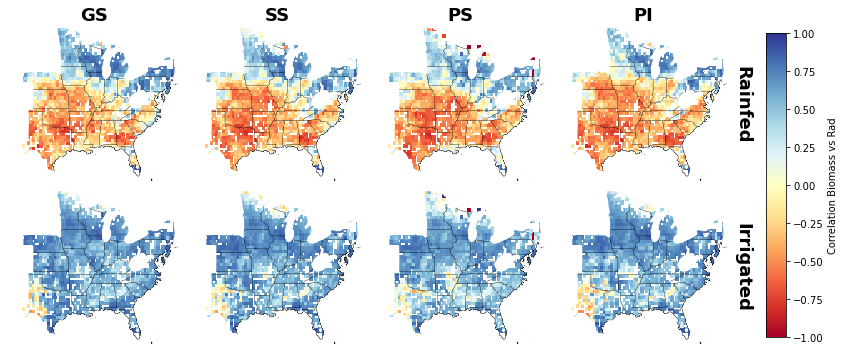

In [350]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='RadiationIn'
x='biomass'

#Set index
dfa = df.set_index(['lat','lon','cultivar','irr'])

a=dfa.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4','biomass'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.RadiationIn.plot(x='lon', y='lat', col='cultivar', row='irr', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("PS", fontsize=18, fontweight="bold")    
axes[3].set_title("PI", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "k", linewidth=2)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "k", color='k', linewidth=2)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.05, hspace=-0.4)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=15, label='Correlation Biomass vs Rad')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\radcorr.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot correlation between water stress factor on expansion (`sw_stress_expan`) and biomass

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-307-5514c90b04ad>:97: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


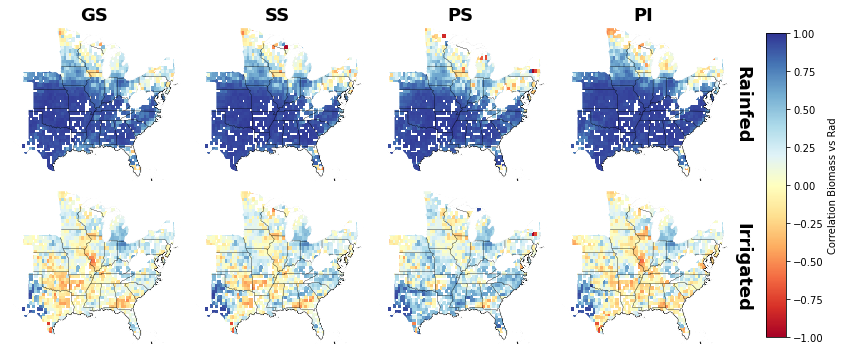

In [307]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='biomass'
x='sw_stress_expan'

#Set index
dfa = df.set_index(['lat','lon','cultivar','irr'])

a=dfa.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.biomass.plot(x='lon', y='lat', col='cultivar', row='irr', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("PS", fontsize=18, fontweight="bold")    
axes[3].set_title("PI", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "k", linewidth=2)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "k", color='k', linewidth=2)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.05, hspace=-0.4)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=15, label='Correlation Biomass vs Rad')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\biomass vs sw.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot correlation between temperature stress factor on RUE from 80DAS to harvest (`tp80_harv`) and biomass

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-73-eb9aa6339682>:97: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


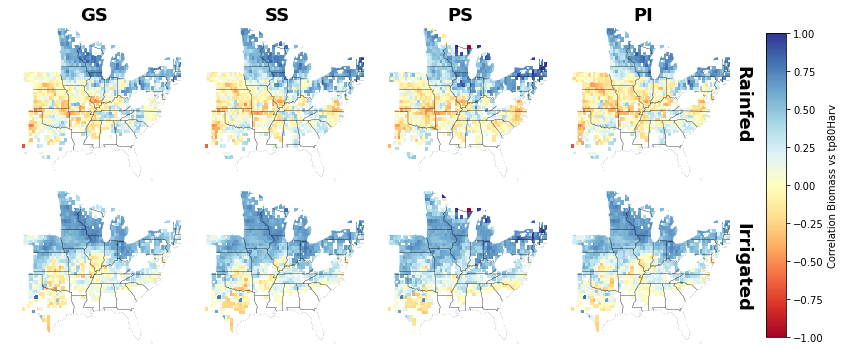

In [73]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='biomass'
x='tp80_harv'

#Set index
dfa = df.set_index(['lat','lon','cultivar','irr'])

a=dfa.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.biomass.plot(x='lon', y='lat', col='cultivar', row='irr', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("PS", fontsize=18, fontweight="bold")    
axes[3].set_title("PI", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.05, hspace=-0.4)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=15, label='Correlation Biomass vs tp80Harv')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\biomass vs sw.png', dpi=600, bbox_inches='tight', pad_inches=0)

hide_toggle()

### Plot correlation between irrigation applied during the growing season (`IrrigationIn`) and biomass

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-307-48948d076493>:99: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


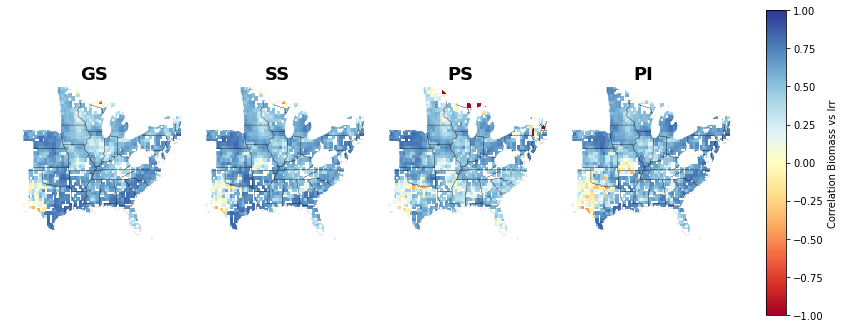

In [307]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='IrrigationIn'
x='biomass'

#Set index
dfa = df.set_index(['lat','lon','cultivar','irr'])

a=dfa.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4','biomass'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.IrrigationIn.plot(x='lon', y='lat', col='cultivar', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(16,8), #rasterized=True
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("PS", fontsize=18, fontweight="bold")    
axes[3].set_title("PI", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.05, hspace=0)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=15, label='Correlation Biomass vs Irr')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\irricorr.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Plot correlation between planting date (`DOY`) and biomass

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-74-17c13fcaa02d>:99: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


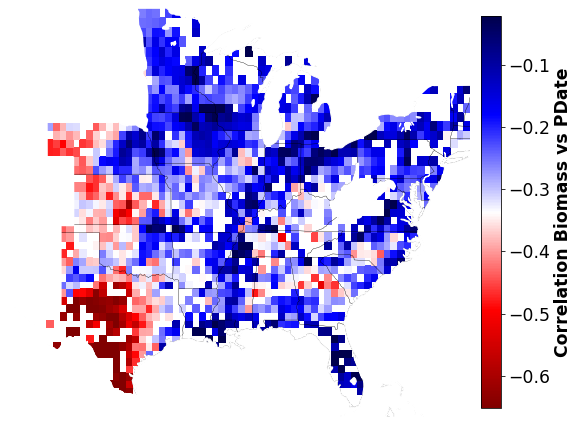

In [74]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='biomass'
x='DOY'

#Set index
dfa = df.set_index(['lat','lon'])

a=dfa.groupby(['lat','lon'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()

#Drop duplicates
e = c.drop_duplicates(['lat','lon'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

a = df.groupby(['lat', 'lon'],as_index=False).mean()
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

p=corr.biomass.plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.seismic_r, zorder=1, add_colorbar=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='Correlation Biomass vs PDate', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\pdate.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()
hide_toggle()

### Plot correlation between irrigation applied during the growing season (`IrrigationIn`) and water stress factor (`sw_stress_expan`)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-111-62b63096f234>:99: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


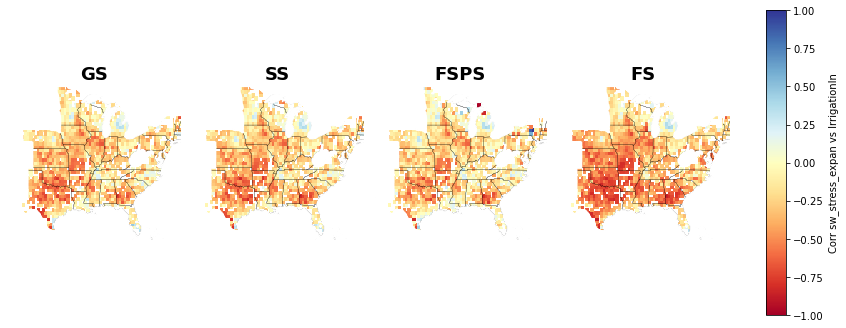

In [111]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='sw_stress_expan'
x='IrrigationIn'

#Set index
dfa = df.set_index(['lat','lon','cultivar','irr'])

a=dfa.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.sw_stress_expan.plot(x='lon', y='lat', col='cultivar', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(16,8), #rasterized=True
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("PS", fontsize=18, fontweight="bold")    
axes[3].set_title("PI", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")
    
#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.05, hspace=0)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=15, label='Corr sw_stress_expan vs IrrigationIn')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\sw vs Irri.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

# <font color='blue'>5- Prepare dataset for heatmap analysis including environment clustering</font>
Here a csv file (`dfenv2.csv`) is required to include names of environemnts in the complete dataframe

In [75]:
#Read dataframe with env names
X= pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\dfenv2.csv')
X0=X.drop(['rain_a', 'radn_a', 'rain_b', 'radn_b', 'rain_c',
       'radn_c', 'wind_a', 'hur_a', 'hurtmax_a', 'cropland_a', 'tmax_a',
       'tmin_a', 'tmean_a', 'wind_b', 'hur_b', 'hurtmax_b', 'cropland_b',
       'tmax_b', 'tmin_b', 'tmean_b', 'wind_c', 'hur_c', 'hurtmax_c',
       'cropland_c', 'tmax_c', 'tmin_c', 'tmean_c', 'radn', 'rain', 'tmin',
       'tmax', 'tmean', 'wind', 'hur', 'hurtmax', 'cropland', 'irr',
       'cultivar', 'time', 'DOY', 'DaysAfterSowing', 'ESW1av', 'FloweringDAS',
       'IrrigationIn', 'LeafNo', 'MaxLAI', 'N_stress_expan', 'N_stress_photo',
       'PAWC', 'RadiationIn', 'RainIn', 'TempIn', 'WU', 'aMaxT', 'aMinT',
       'actual_ET', 'biomass', 'planting_date', 'potential_ET', 'rad40DAS',
       'rad80DAS', 'radHarv', 'rain40DAS', 'rain80DAS', 'rainHarv', 'ri0_40',
       'ri40_80', 'ri80_harv', 'scen', 'sw0_40', 'sw40_80', 'sw80_harv',
       'sw_stress_expan', 'sw_stress_photo', 'temp40DAS', 'temp80DAS',
       'tempHarv', 'tp0_40', 'tp40_80', 'tp80_harv',], axis=1)

#Merge current dataset to include envs
dfa = pd.merge(X0, df, how ='inner', on =['lat','lon']) 
dfa.rename(columns={'env_name_x':'env_name','cropland_x':'cropland'}, inplace=True)
dfa0 = dfa.dropna()
dfa3 = dfa0.reset_index()

In [76]:
dfa3.biomass2.min()
dfa3[dfa3['biomass2'] == 5.789100170135498]

index    lat    lon  env env_name  cultivar  irr  time      rain_a  \
270998  282152  43.75 -89.25    1      Low         2    2     3  206.195423   

             radn_a  ...  sw80_harv  sw_stress_expan  sw_stress_photo  \
270998  1291.711554  ...        1.0            0.916            0.916   

        temp40DAS  temp80DAS  tempHarv  tp0_40  tp40_80  tp80_harv  biomass2  
270998  17.618999     21.052    15.217   0.761    0.953      0.592    5.7891  

[1 rows x 86 columns]

### Calculate statistics

In [77]:
dfa4 = dfa3.loc[dfa3['FloweringDAS'] != 0]

stat_mean = dfa4.groupby(['cultivar','irr','env_name'],as_index=False).mean()
stat_sd = dfa4.groupby(['cultivar','irr','env_name'],as_index=False).std()
stat_c = dfa4.groupby(['cultivar','irr','env_name'],as_index=False).count()
#stat_mean.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\validationStatMean.csv')
#stat_sd.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\validationStatSD.csv')
#stat_c.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\validationStatc.csv')

stat_mean.loc[stat_mean.cultivar == 0, 'cv'] = "GS"
stat_mean.loc[stat_mean.cultivar == 1, 'cv'] = "SS"
stat_mean.loc[stat_mean.cultivar == 2, 'cv'] = "PS"
stat_mean.loc[stat_mean.cultivar == 3, 'cv'] = "PI"

### Plot Biomass vs Flowering Date and Harvesting Date

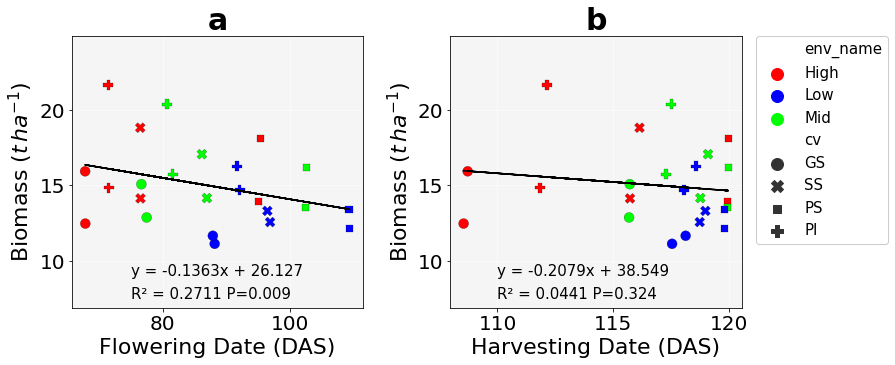

In [78]:
color_dict = dict({'High': '#ff0101','Mid':'#00ff01','Low':'#0000fe'})
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(12,5))

ax=plt.subplot(1, 2, 1)
sns.scatterplot(x="FloweringDAS", y="biomass2", hue='env_name',style='cv', alpha=1, data=stat_mean, linewidth=0.2,**kwargs,s=100, palette=color_dict)

# Formatting graph and background
plt.legend(prop=dict(size=15),bbox_to_anchor=(2.35, 1), loc=2, borderaxespad=0., ncol=1,framealpha=1,markerscale=2)
plt.ylabel('Biomass ($t\,ha^{-1}$)', fontsize=22)
plt.xlabel('Flowering Date (DAS)', fontsize =22)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.set_xlim([10.1,32.9])
ax.set_ylim([6.9,24.9])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()
#ax.set_title('b',fontsize= 30,weight='bold') 

y=stat_mean.biomass2.values
x=stat_mean.FloweringDAS.values

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b,color='k')

plt.title('a',fontsize=30, fontweight='bold')
plt.text(75, 9,'y = -0.1363x + 26.127', fontsize=15,color='k')
plt.text(75, 7.5,'R² = 0.2711 P=0.009', fontsize=15,color='k')

##################################################################
ax=plt.subplot(1, 2, 2)
sns.scatterplot(x="DaysAfterSowing", y="biomass2", hue='env_name', style='cv', alpha=1, data=stat_mean, linewidth=0.2,**kwargs,s=100, palette=color_dict)

# Formatting graph and background
plt.legend(prop=dict(size=12),bbox_to_anchor=(0.1, 0.9), loc=2, borderaxespad=0., ncol=1,framealpha=1,markerscale=2)
plt.ylabel('Biomass ($t\,ha^{-1}$)', fontsize =22)
plt.xlabel('Harvesting Date (DAS)', fontsize =22)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.set_xlim([10.1,32.9])
ax.set_ylim([6.9,24.9])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()
#ax.set_title('b',fontsize= 30,weight='bold') 

y=stat_mean.biomass2.values
x=stat_mean.DaysAfterSowing.values

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b,color='k')

plt.title('b',fontsize=30, fontweight='bold')
plt.text(110, 9,'y = -0.2079x + 38.549', fontsize=15,color='k')
plt.text(110, 7.5,'R² = 0.0441 P=0.324', fontsize=15,color='k')
####################################################################
plt.subplots_adjust(wspace=0.3, hspace=0)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\fre2.png', dpi=600, bbox_inches='tight', pad_inches=0)

In [325]:
stat_mean[stat_mean['biomass2'] == 21.644567]

cultivar  irr env_name          index        lat        lon  env  time  \
21         3    2     High  101000.373016  34.941358 -92.291446  0.0  15.5   

        rain_a       radn_a  ...  sw80_harv  sw_stress_expan  sw_stress_photo  \
21  232.910814  1438.202828  ...   0.979666         0.930155         0.941985   

    temp40DAS  temp80DAS   tempHarv    tp0_40   tp40_80  tp80_harv   biomass2  
21  23.589808  26.840187  26.200039  0.975791  0.999211   0.988641  21.644567  

[1 rows x 86 columns]

In [93]:
dfa3.loc[dfa3['biomass2'] < 5.79]

index    lat    lon  env env_name  cultivar  irr      rain_a  \
247266  247266  42.25 -75.25    1      Low         0    1  222.515609   
270998  270998  43.75 -89.25    1      Low         2    2  206.195423   
272576  272576  43.75 -84.75    1      Low         2    1  173.750965   
296178  296178  46.75 -88.75    1      Low         0    1  155.665701   

             radn_a      rain_b  ...  sw80_harv  sw_stress_expan  \
247266  1227.625141  252.850492  ...        1.0            0.817   
270998  1291.711554  248.470690  ...        1.0            0.916   
272576  1303.760911  179.435159  ...        1.0            0.983   
296178  1340.398606  192.758750  ...        1.0            0.980   

        sw_stress_photo  temp40DAS  temp80DAS  tempHarv  tp0_40  tp40_80  \
247266            0.817  20.132999  19.493999    15.414   0.908    0.897   
270998            0.916  17.618999  21.052000    15.217   0.761    0.953   
272576            0.983  20.362000  18.108999    14.935   0.943    0.812   
296178            0.980  18.466999  18.327999    12.448   0.824    0.838   

        tp80_harv  biomass2  
247266      0.598    5.7896  
270998      0.592    5.7891  
272576      0.551    5.7899  
296178      0.377    5.7896  

[4 rows x 85 columns]

# <font color='blue'>6- Export data for Variance Decomposition Analysis</font>
The exported dataset was used to quantify the contribution of each factor on the biomass variance (see `VarDecomp.ipynb` in my VarianceDecomposition repo)

In [327]:
dfa = dfa3.dropna()
var1 = dfa.groupby(['env_name','irr', 'lat', 'lon', 'cultivar'],as_index=False).mean()
var=var1.drop(['DaysAfterSowing', 'planting_date', 'scen','aMaxT','aMinT','IrrigationIn','FloweringDAS','biomass2'], axis=1)
#var.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\var.csv')

# <font color='blue'>7- Heatmap analysis</font>

### Create filters, rearrange dataframes and plot heatmap of correlations between stress factors and biomass

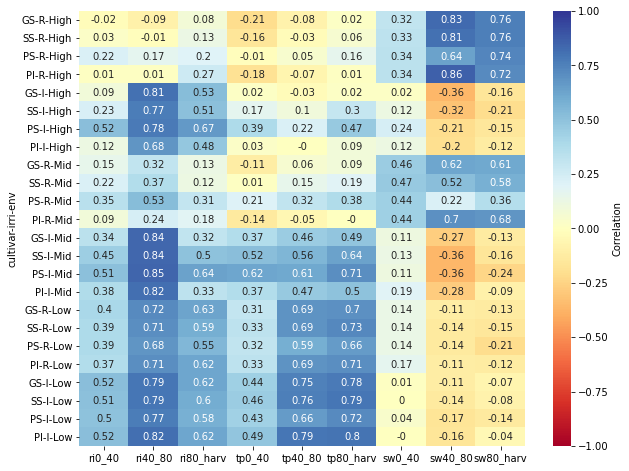

In [78]:
A = dfa3.loc[dfa3['env_name'] == 'High']
B = dfa3.loc[dfa3['env_name'] == 'Mid']
C = dfa3.loc[dfa3['env_name'] == 'Low']

Adry = A.loc[A['irr'] == 1]
Airri = A.loc[A['irr'] == 2]
Bdry = B.loc[B['irr'] == 1]
Birri = B.loc[B['irr'] == 2]
Cdry = C.loc[C['irr'] == 1]
Cirri = C.loc[C['irr'] == 2]

AGSd = Adry.loc[Adry['cultivar'] == 0]
ASSd = Adry.loc[Adry['cultivar'] == 1]
AFSPSd = Adry.loc[Adry['cultivar'] == 2]
AFSd = Adry.loc[Adry['cultivar'] == 3]
AGSi = Airri.loc[Airri['cultivar'] == 0]
ASSi = Airri.loc[Airri['cultivar'] == 1]
AFSPSi = Airri.loc[Airri['cultivar'] == 2]
AFSi = Airri.loc[Airri['cultivar'] == 3]

BGSd = Bdry.loc[Bdry['cultivar'] == 0]
BSSd = Bdry.loc[Bdry['cultivar'] == 1]
BFSPSd = Bdry.loc[Bdry['cultivar'] == 2]
BFSd = Bdry.loc[Bdry['cultivar'] == 3]
BGSi = Birri.loc[Birri['cultivar'] == 0]
BSSi = Birri.loc[Birri['cultivar'] == 1]
BFSPSi = Birri.loc[Birri['cultivar'] == 2]
BFSi = Birri.loc[Birri['cultivar'] == 3]

CGSd = Cdry.loc[Cdry['cultivar'] == 0]
CSSd = Cdry.loc[Cdry['cultivar'] == 1]
CFSPSd = Cdry.loc[Cdry['cultivar'] == 2]
CFSd = Cdry.loc[Cdry['cultivar'] == 3]
CGSi = Cirri.loc[Cirri['cultivar'] == 0]
CSSi = Cirri.loc[Cirri['cultivar'] == 1]
CFSPSi = Cirri.loc[Cirri['cultivar'] == 2]
CFSi = Cirri.loc[Cirri['cultivar'] == 3]

AGSdcorr = AGSd.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
AGSdcorr['cultivar'] = 'GS'
AGSdcorr['irri'] = 'R'
AGSdcorr['env'] = 'High'
AFSdcorr = AFSd.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
AFSdcorr['cultivar'] = 'PI'
AFSdcorr['irri'] = 'R'
AFSdcorr['env'] = 'High'
ASSdcorr = ASSd.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
ASSdcorr['cultivar'] = 'SS'
ASSdcorr['irri'] = 'R'
ASSdcorr['env'] = 'High'
AFSPSdcorr = AFSPSd.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
AFSPSdcorr['cultivar'] = 'PS'
AFSPSdcorr['irri'] = 'R'
AFSPSdcorr['env'] = 'High'

AGSicorr = AGSi.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
AGSicorr['cultivar'] = 'GS'
AGSicorr['irri'] = 'I'
AGSicorr['env'] = 'High'
AFSicorr = AFSi.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
AFSicorr['cultivar'] = 'PI'
AFSicorr['irri'] = 'I'
AFSicorr['env'] = 'High'
ASSicorr = ASSi.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
ASSicorr['cultivar'] = 'SS'
ASSicorr['irri'] = 'I'
ASSicorr['env'] = 'High'
AFSPSicorr = AFSPSi.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
AFSPSicorr['cultivar'] = 'PS'
AFSPSicorr['irri'] = 'I'
AFSPSicorr['env'] = 'High'

BGSdcorr = BGSd.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
BGSdcorr['cultivar'] = 'GS'
BGSdcorr['irri'] = 'R'
BGSdcorr['env'] = 'Mid'
BFSdcorr = BFSd.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
BFSdcorr['cultivar'] = 'PI'
BFSdcorr['irri'] = 'R'
BFSdcorr['env'] = 'Mid'
BSSdcorr = BSSd.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
BSSdcorr['cultivar'] = 'SS'
BSSdcorr['irri'] = 'R'
BSSdcorr['env'] = 'Mid'
BFSPSdcorr = BFSPSd.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
BFSPSdcorr['cultivar'] = 'PS'
BFSPSdcorr['irri'] = 'R'
BFSPSdcorr['env'] = 'Mid'

BGSicorr = BGSi.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
BGSicorr['cultivar'] = 'GS'
BGSicorr['irri'] = 'I'
BGSicorr['env'] = 'Mid'
BFSicorr = BFSi.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
BFSicorr['cultivar'] = 'PI'
BFSicorr['irri'] = 'I'
BFSicorr['env'] = 'Mid'
BSSicorr = BSSi.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
BSSicorr['cultivar'] = 'SS'
BSSicorr['irri'] = 'I'
BSSicorr['env'] = 'Mid'
BFSPSicorr = BFSPSi.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
BFSPSicorr['cultivar'] = 'PS'
BFSPSicorr['irri'] = 'I'
BFSPSicorr['env'] = 'Mid'

CGSdcorr = CGSd.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
CGSdcorr['cultivar'] = 'GS'
CGSdcorr['irri'] = 'R'
CGSdcorr['env'] = 'Low'
CFSdcorr = CFSd.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
CFSdcorr['cultivar'] = 'PI'
CFSdcorr['irri'] = 'R'
CFSdcorr['env'] = 'Low'
CSSdcorr = CSSd.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
CSSdcorr['cultivar'] = 'SS'
CSSdcorr['irri'] = 'R'
CSSdcorr['env'] = 'Low'
CFSPSdcorr = CFSPSd.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
CFSPSdcorr['cultivar'] = 'PS'
CFSPSdcorr['irri'] = 'R'
CFSPSdcorr['env'] = 'Low'

CGSicorr = CGSi.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
CGSicorr['cultivar'] = 'GS'
CGSicorr['irri'] = 'I'
CGSicorr['env'] = 'Low'
CFSicorr = CFSi.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
CFSicorr['cultivar'] = 'PI'
CFSicorr['irri'] = 'I'
CFSicorr['env'] = 'Low'
CSSicorr = CSSi.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
CSSicorr['cultivar'] = 'SS'
CSSicorr['irri'] = 'I'
CSSicorr['env'] = 'Low'
CFSPSicorr = CFSPSi.corr().loc[['biomass'],['ri0_40', 'ri40_80', 'ri80_harv','tp0_40', 'tp40_80', 'tp80_harv','sw0_40', 'sw40_80', 'sw80_harv']]
CFSPSicorr['cultivar'] = 'PS'
CFSPSicorr['irri'] = 'I'
CFSPSicorr['env'] = 'Low'

frames = [AGSdcorr,ASSdcorr,AFSPSdcorr,AFSdcorr,AGSicorr,ASSicorr,AFSPSicorr,AFSicorr,
          BGSdcorr,BSSdcorr,BFSPSdcorr,BFSdcorr,BGSicorr,BSSicorr,BFSPSicorr,BFSicorr,
          CGSdcorr,CSSdcorr,CFSPSdcorr,CFSdcorr,CGSicorr,CSSicorr,CFSPSicorr,CFSicorr]

corr = pd.concat(frames)
corr.reset_index(level=[0], inplace=True)

df_final=corr.drop(['index'], axis=1)
df1 = df_final.set_index(['cultivar','irri','env'])
df2 = df1.round(decimals=2)

#Plot heatmap
fig= plt.figure(figsize=(10,8))
sns.heatmap(df2, annot=True, cmap='RdYlBu',vmin=-1, vmax=1,
        cbar_kws={
        "orientation": "vertical",
        "shrink": 1,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Correlation"})

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\figs\corr.png', dpi=300, bbox_inches='tight', pad_inches=0)

hide_toggle()

### Improve visualisation of the heatmap
The following two cells are mandatory before to create the plot

In [79]:
df_corr = df2.reset_index()

In [80]:
df_corr2 = df_corr.set_index(['cultivar','irri'])

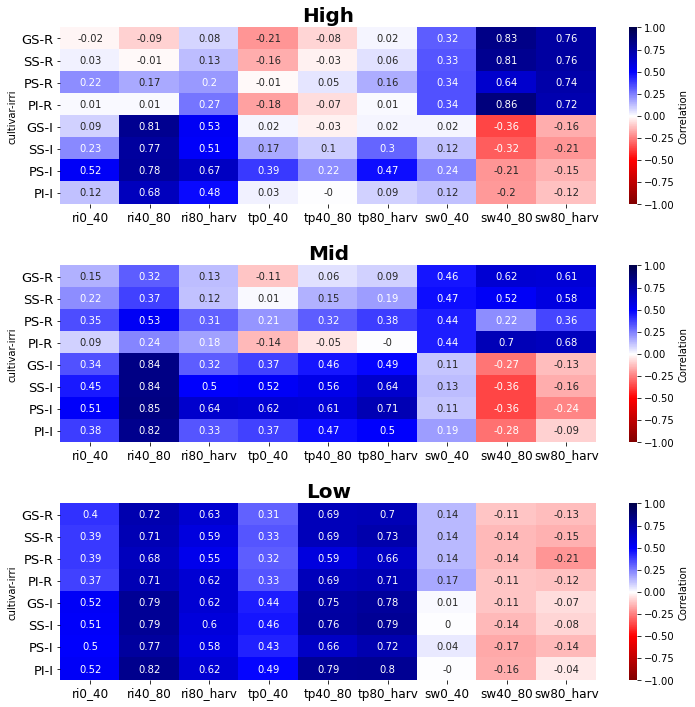

In [81]:
A = df_corr2.loc[df_corr2['env'] == 'High']
A2 = A.drop(['env'], axis=1)
B = df_corr2.loc[df_corr2['env'] == 'Mid']
B2 = B.drop(['env'], axis=1)
C = df_corr2.loc[df_corr2['env'] == 'Low']
C2 = C.drop(['env'], axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,12))
sns.heatmap(A2, ax=ax1, annot=True, cmap='seismic_r',vmin=-1, vmax=1,
        cbar_kws={
        "orientation": "vertical",
        "shrink": 1,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Correlation"})
sns.heatmap(B2, ax=ax2, annot=True, cmap='seismic_r',vmin=-1, vmax=1,
        cbar_kws={
        "orientation": "vertical",
        "shrink": 1,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Correlation"})
sns.heatmap(C2, ax=ax3, annot=True, cmap='seismic_r',vmin=-1, vmax=1,
        cbar_kws={
        "orientation": "vertical",
        "shrink": 1,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Correlation"})

ax1.set_title('High', fontweight='bold', size=20)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=13)

ax2.set_title('Mid', fontweight='bold', size=20)
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=13)

ax3.set_title('Low', fontweight='bold', size=20)
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=13)

plt.subplots_adjust(wspace=0, hspace=0.35)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\corr2.png', dpi=300, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Create filters, rearrange dataframes and plot heatmap of correlations between environmental variables and biomass

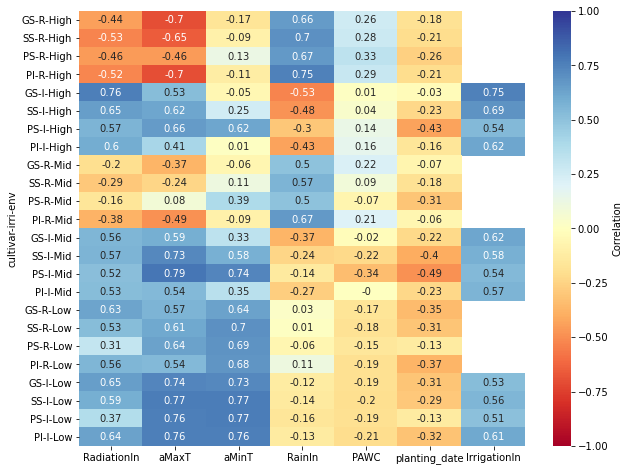

In [82]:
#Create filters and rearrange dataframes
A = dfa3.loc[dfa3['env_name'] == 'High']
B = dfa3.loc[dfa3['env_name'] == 'Mid']
C = dfa3.loc[dfa3['env_name'] == 'Low']

Adry = A.loc[A['irr'] == 1]
Airri = A.loc[A['irr'] == 2]
Bdry = B.loc[B['irr'] == 1]
Birri = B.loc[B['irr'] == 2]
Cdry = C.loc[C['irr'] == 1]
Cirri = C.loc[C['irr'] == 2]

AGSd = Adry.loc[Adry['cultivar'] == 0]
ASSd = Adry.loc[Adry['cultivar'] == 1]
AFSPSd = Adry.loc[Adry['cultivar'] == 2]
AFSd = Adry.loc[Adry['cultivar'] == 3]
AGSi = Airri.loc[Airri['cultivar'] == 0]
ASSi = Airri.loc[Airri['cultivar'] == 1]
AFSPSi = Airri.loc[Airri['cultivar'] == 2]
AFSi = Airri.loc[Airri['cultivar'] == 3]

BGSd = Bdry.loc[Bdry['cultivar'] == 0]
BSSd = Bdry.loc[Bdry['cultivar'] == 1]
BFSPSd = Bdry.loc[Bdry['cultivar'] == 2]
BFSd = Bdry.loc[Bdry['cultivar'] == 3]
BGSi = Birri.loc[Birri['cultivar'] == 0]
BSSi = Birri.loc[Birri['cultivar'] == 1]
BFSPSi = Birri.loc[Birri['cultivar'] == 2]
BFSi = Birri.loc[Birri['cultivar'] == 3]

CGSd = Cdry.loc[Cdry['cultivar'] == 0]
CSSd = Cdry.loc[Cdry['cultivar'] == 1]
CFSPSd = Cdry.loc[Cdry['cultivar'] == 2]
CFSd = Cdry.loc[Cdry['cultivar'] == 3]
CGSi = Cirri.loc[Cirri['cultivar'] == 0]
CSSi = Cirri.loc[Cirri['cultivar'] == 1]
CFSPSi = Cirri.loc[Cirri['cultivar'] == 2]
CFSi = Cirri.loc[Cirri['cultivar'] == 3]

AGSdcorr = AGSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
AGSdcorr['cultivar'] = 'GS'
AGSdcorr['irri'] = 'R'
AGSdcorr['env'] = 'High'
AFSdcorr = AFSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
AFSdcorr['cultivar'] = 'PI'
AFSdcorr['irri'] = 'R'
AFSdcorr['env'] = 'High'
ASSdcorr = ASSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
ASSdcorr['cultivar'] = 'SS'
ASSdcorr['irri'] = 'R'
ASSdcorr['env'] = 'High'
AFSPSdcorr = AFSPSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
AFSPSdcorr['cultivar'] = 'PS'
AFSPSdcorr['irri'] = 'R'
AFSPSdcorr['env'] = 'High'

AGSicorr = AGSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
AGSicorr['cultivar'] = 'GS'
AGSicorr['irri'] = 'I'
AGSicorr['env'] = 'High'
AFSicorr = AFSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
AFSicorr['cultivar'] = 'PI'
AFSicorr['irri'] = 'I'
AFSicorr['env'] = 'High'
ASSicorr = ASSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
ASSicorr['cultivar'] = 'SS'
ASSicorr['irri'] = 'I'
ASSicorr['env'] = 'High'
AFSPSicorr = AFSPSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
AFSPSicorr['cultivar'] = 'PS'
AFSPSicorr['irri'] = 'I'
AFSPSicorr['env'] = 'High'

BGSdcorr = BGSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
BGSdcorr['cultivar'] = 'GS'
BGSdcorr['irri'] = 'R'
BGSdcorr['env'] = 'Mid'
BFSdcorr = BFSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
BFSdcorr['cultivar'] = 'PI'
BFSdcorr['irri'] = 'R'
BFSdcorr['env'] = 'Mid'
BSSdcorr = BSSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
BSSdcorr['cultivar'] = 'SS'
BSSdcorr['irri'] = 'R'
BSSdcorr['env'] = 'Mid'
BFSPSdcorr = BFSPSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
BFSPSdcorr['cultivar'] = 'PS'
BFSPSdcorr['irri'] = 'R'
BFSPSdcorr['env'] = 'Mid'

BGSicorr = BGSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
BGSicorr['cultivar'] = 'GS'
BGSicorr['irri'] = 'I'
BGSicorr['env'] = 'Mid'
BFSicorr = BFSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
BFSicorr['cultivar'] = 'PI'
BFSicorr['irri'] = 'I'
BFSicorr['env'] = 'Mid'
BSSicorr = BSSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
BSSicorr['cultivar'] = 'SS'
BSSicorr['irri'] = 'I'
BSSicorr['env'] = 'Mid'
BFSPSicorr = BFSPSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
BFSPSicorr['cultivar'] = 'PS'
BFSPSicorr['irri'] = 'I'
BFSPSicorr['env'] = 'Mid'

CGSdcorr = CGSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
CGSdcorr['cultivar'] = 'GS'
CGSdcorr['irri'] = 'R'
CGSdcorr['env'] = 'Low'
CFSdcorr = CFSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
CFSdcorr['cultivar'] = 'PI'
CFSdcorr['irri'] = 'R'
CFSdcorr['env'] = 'Low'
CSSdcorr = CSSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
CSSdcorr['cultivar'] = 'SS'
CSSdcorr['irri'] = 'R'
CSSdcorr['env'] = 'Low'
CFSPSdcorr = CFSPSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
CFSPSdcorr['cultivar'] = 'PS'
CFSPSdcorr['irri'] = 'R'
CFSPSdcorr['env'] = 'Low'

CGSicorr = CGSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
CGSicorr['cultivar'] = 'GS'
CGSicorr['irri'] = 'I'
CGSicorr['env'] = 'Low'
CFSicorr = CFSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
CFSicorr['cultivar'] = 'PI'
CFSicorr['irri'] = 'I'
CFSicorr['env'] = 'Low'
CSSicorr = CSSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
CSSicorr['cultivar'] = 'SS'
CSSicorr['irri'] = 'I'
CSSicorr['env'] = 'Low'
CFSPSicorr = CFSPSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC','planting_date','IrrigationIn']]
CFSPSicorr['cultivar'] = 'PS'
CFSPSicorr['irri'] = 'I'
CFSPSicorr['env'] = 'Low'

frames = [AGSdcorr,ASSdcorr,AFSPSdcorr,AFSdcorr,AGSicorr,ASSicorr,AFSPSicorr,AFSicorr,
          BGSdcorr,BSSdcorr,BFSPSdcorr,BFSdcorr,BGSicorr,BSSicorr,BFSPSicorr,BFSicorr,
          CGSdcorr,CSSdcorr,CFSPSdcorr,CFSdcorr,CGSicorr,CSSicorr,CFSPSicorr,CFSicorr]

corr = pd.concat(frames)
corr.reset_index(level=[0], inplace=True)

df_final=corr.drop(['index'], axis=1)
df1 = df_final.set_index(['cultivar','irri','env'])
df2 = df1.round(decimals=2)

#Plot heatmap
fig= plt.figure(figsize=(10,8))
sns.heatmap(df2, annot=True, cmap='RdYlBu',vmin=-1, vmax=1,
        cbar_kws={
        "orientation": "vertical",
        "shrink": 1,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Correlation"})

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\figs\corr.png', dpi=300, bbox_inches='tight', pad_inches=0)

hide_toggle()

### Improve visualisation of the heatmap

In [83]:
df_corr = df2.reset_index()

In [84]:
df_corr2 = df_corr.set_index(['cultivar','irri'])

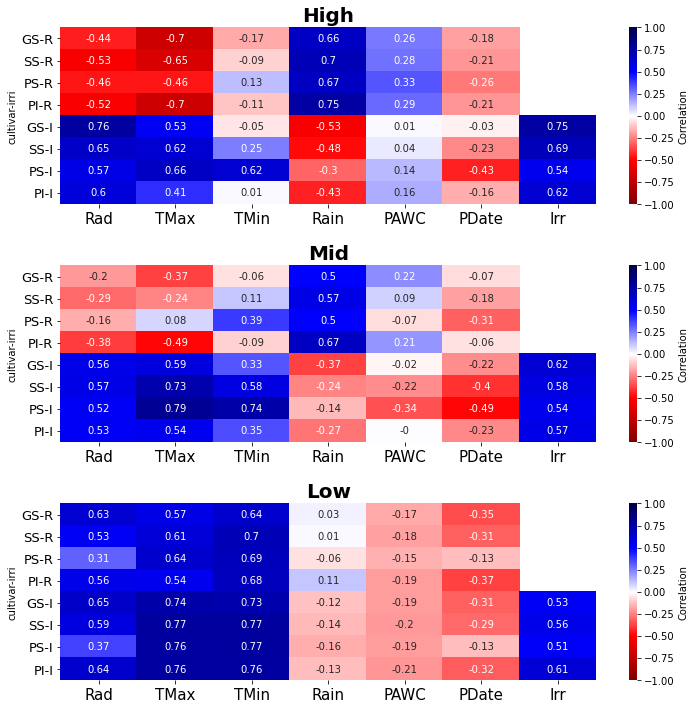

In [85]:
df_corr2.rename(columns={'RadiationIn':'Rad','aMaxT':'TMax','aMinT':'TMin',
                        'RainIn':'Rain','actual_ET':'ET','IrrigationIn':'Irr','radInt':'RadInt','planting_date':'PDate'}, inplace=True)

A = df_corr2.loc[df_corr2['env'] == 'High']
A2 = A.drop(['env'], axis=1)
B = df_corr2.loc[df_corr2['env'] == 'Mid']
B2 = B.drop(['env'], axis=1)
C = df_corr2.loc[df_corr2['env'] == 'Low']
C2 = C.drop(['env'], axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,12))
sns.heatmap(A2, ax=ax1, annot=True, cmap='seismic_r',vmin=-1, vmax=1,
        cbar_kws={
        "orientation": "vertical",
        "shrink": 1,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Correlation"})
sns.heatmap(B2, ax=ax2, annot=True, cmap='seismic_r',vmin=-1, vmax=1,
        cbar_kws={
        "orientation": "vertical",
        "shrink": 1,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Correlation"})
sns.heatmap(C2, ax=ax3, annot=True, cmap='seismic_r',vmin=-1, vmax=1,
        cbar_kws={
        "orientation": "vertical",
        "shrink": 1,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Correlation"})

ax1.set_title('High', fontweight='bold', size=20)
ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=13)

ax2.set_title('Mid', fontweight='bold', size=20)
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=13)

ax3.set_title('Low', fontweight='bold', size=20)
ax3.xaxis.set_tick_params(labelsize=15)
ax3.yaxis.set_tick_params(labelsize=13)

plt.subplots_adjust(wspace=0, hspace=0.35)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\corr.png', dpi=300, bbox_inches='tight', pad_inches=0)
hide_toggle()

# <font color='blue'>8- Additional analysis</font>

### Probability density function of sorghum biomass during 30 growing seasons (1980-2009) for each genotype [grain sorghum (GS), sorghum sudangrass (SS), forage photosensitive sorghum, (PS) and forage photo insensitive sorghum (PI)] and irrigation strategy (rainfed and irrigated) in three clustered environments (High, Mid and Low).

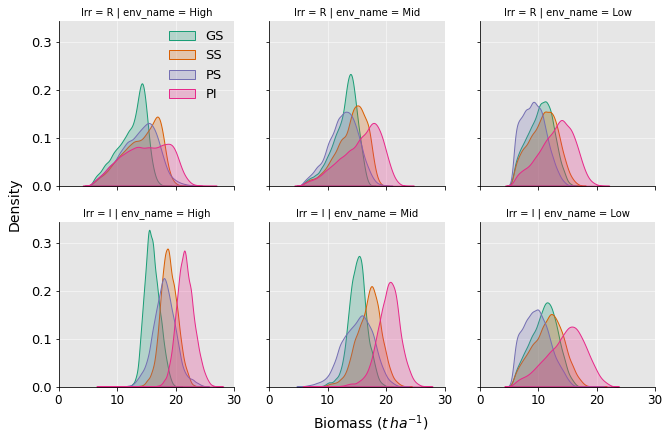

In [86]:
#Density plot#

dfa3.loc[dfa3.cultivar == 0, 'cv'] = "GS"
dfa3.loc[dfa3.cultivar == 1, 'cv'] = "SS"
dfa3.loc[dfa3.cultivar == 2, 'cv'] = "PS"
dfa3.loc[dfa3.cultivar == 3, 'cv'] = "PI"

dfa3.loc[dfa3.irr == 1, 'Irr'] = "R"
dfa3.loc[dfa3.irr == 2, 'Irr'] = "I"

g = sns.FacetGrid(dfa3, col="env_name", row='Irr', hue="cv",hue_order= ['GS','SS','PS','PI'], col_order=['High','Mid','Low'], sharey=True, height=3,
                  aspect=1, palette='Dark2')

g.map(sns.kdeplot,"biomass2",shade=True, zorder=2)

g.add_legend(fontsize=13,title=False,bbox_to_anchor=(0.31, 0.84))
g.set_xlabels("")
axes = g.axes.flatten()

axes[0].yaxis.set_tick_params(labelsize=13)
axes[3].yaxis.set_tick_params(labelsize=13)
axes[3].set_xlim(0,30)
axes[3].xaxis.set_tick_params(labelsize=12)
axes[3].xaxis.set_major_locator(ticker.MultipleLocator(10))
axes[4].set_xlim(0,30)
axes[4].xaxis.set_tick_params(labelsize=12)
axes[4].xaxis.set_major_locator(ticker.MultipleLocator(10))
axes[5].set_xlim(0,30)
axes[5].xaxis.set_tick_params(labelsize=12)
axes[5].xaxis.set_major_locator(ticker.MultipleLocator(10))

axes[0].grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
axes[0].grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
axes[0].patch.set_facecolor('0.90')
axes[1].grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
axes[1].grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
axes[1].patch.set_facecolor('0.90')
axes[2].grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
axes[2].grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
axes[2].patch.set_facecolor('0.90')
axes[3].grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
axes[3].grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
axes[3].patch.set_facecolor('0.90')
axes[4].grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
axes[4].grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
axes[4].patch.set_facecolor('0.90')
axes[5].grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
axes[5].grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
axes[5].patch.set_facecolor('0.90')

g.fig.text(0.5, 0, 'Biomass ($t\,ha^{-1}$)', ha='center', fontsize =14)
g.fig.text(-0.01, 0.52, 'Density', va='center', rotation='vertical', fontsize =14)
g.fig.subplots_adjust(wspace=0.2, hspace=0.22)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\density.png', dpi=300, bbox_inches='tight', pad_inches=0)
hide_toggle()

### Temporal variability analysis: Biomass and rain vs year

<ipython-input-87-ce5d73a2bf0d>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
No handles with labels found to put in legend.


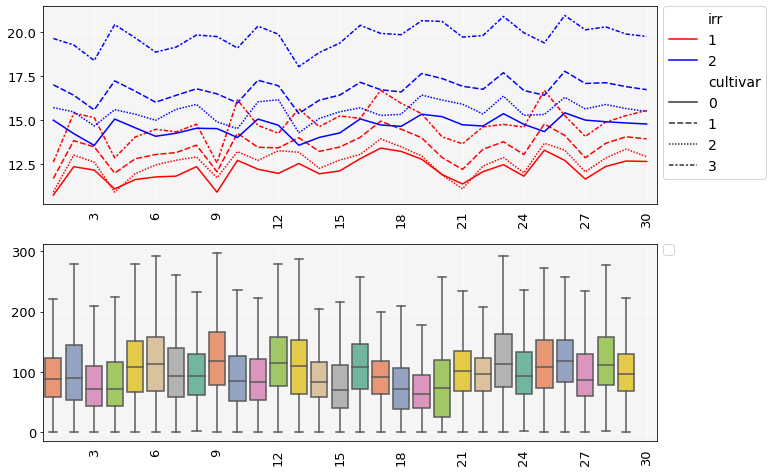

In [87]:
#Biomass vs year#

fig= plt.figure(figsize=(11,8))

ax=plt.subplot(2,1, 1)

ax = sns.lineplot(x="time", y="biomass2",hue="irr", style="cultivar", estimator=np.mean, data=df,
                  ci=95, err_style="band", palette=['r','b'])

# Formatting graph and background
plt.legend(prop=dict(size=14),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.ylabel('', fontsize =15)
plt.xlabel('', fontsize =25)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=13)
ax.xaxis.set_tick_params(labelsize=13)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
#ax.set_ylim([10.1,21.9])
ax.set_xlim([0.5,30.5])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)

ax=plt.subplot(2, 1, 2)

ax = sns.boxplot(x="time", y="rainHarv", data=df, palette='Set2',showfliers = False)

# Formatting graph and background
plt.legend(prop=dict(size=14),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.ylabel('', fontsize =15)
plt.xlabel('', fontsize =25)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=13)
ax.xaxis.set_tick_params(labelsize=13)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
#ax.set_ylim([200,500])
ax.set_xlim([0.5,30.5])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)

### Biomass vs planting date by genotype, irrigation and environemnt

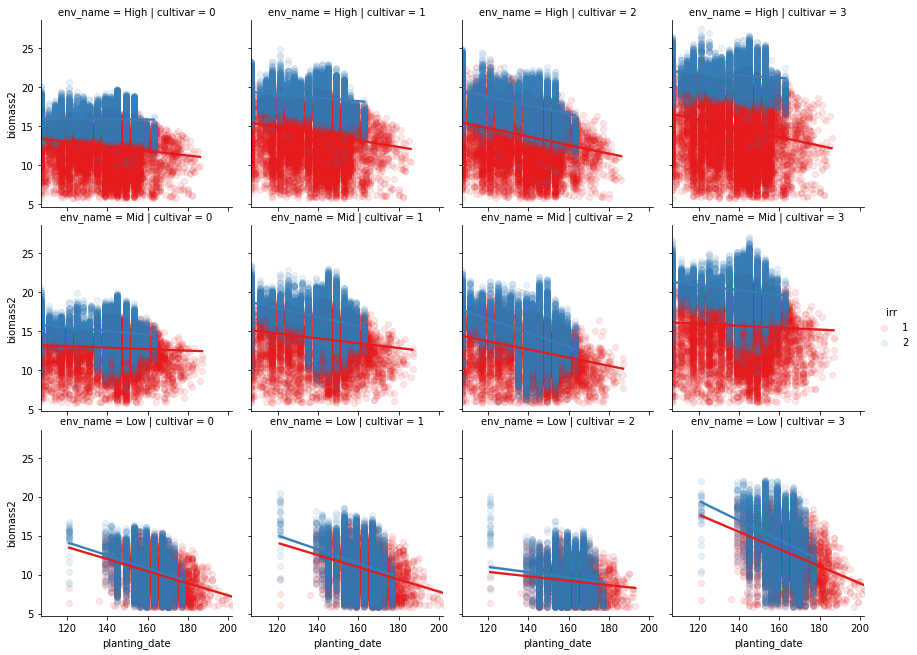

In [88]:
dfa3['AET/ET0'] = dfa3['actual_ET']/dfa3['potential_ET']
sns.lmplot(x="planting_date", y="biomass2",hue='irr',row='env_name',col='cultivar', data=dfa3, palette='Set1',scatter_kws={'alpha':0.1}, height=3)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

### Biomass vs cumulative rainfall during the growing season by environment and irrigation

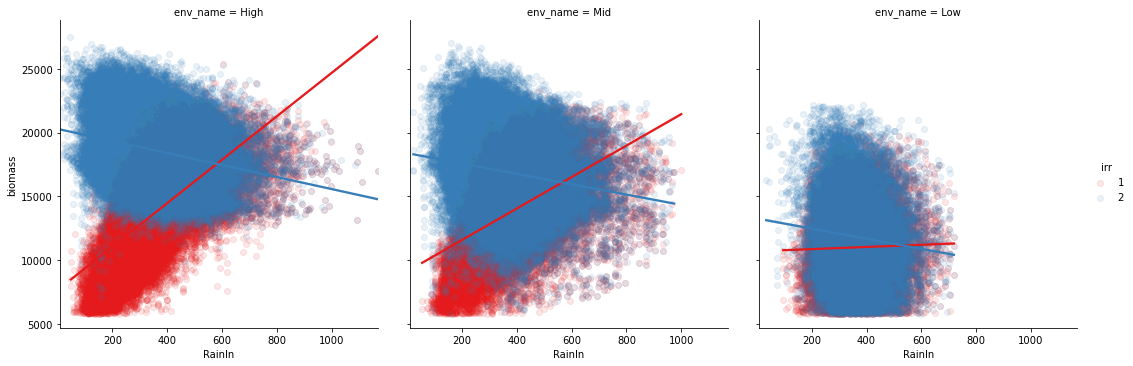

In [89]:
sns.lmplot(x="RainIn", y="biomass",hue='irr',col='env_name', data=dfa3, palette='Set1',scatter_kws={'alpha':0.1})
plt.subplots_adjust(wspace=0.1, hspace=0)